Group members:

Hjalte Reuss Schmidt s163471

Phillip Kragh Aagaard s190736

Maria Lyck Carstensen s144478

## Motivation

The datasets chosen for this projects are the following:
- A network based on collaborating artists - information about which artist that have been collaborating with other artists on various songs was found through the spotify API
- For 5 selected artists (selected based on their high degrees, i.e. very collaborating artists) the follwing datasets were gathered:
    - 5 selected song lyrics which then were NL-analyzed
    - These 5 songs were also audio-analysed based on 9 audio features accessible through the Spotify API
    - The associated wikipedia-pages for the 5 artists were also NL-analyzed

The idea was to see if any insights to how artists decides to collaborate with other artists. Is it based on musical patterns (investigated through the audio feature)? Are there any lyrical themes that traverse through the collaborating artists (investigated through the NL-analysis of the lyrics and wiki-pages)? Are they collaborating with artists that are in moods similar to themselves (investigated through sentiment analysis of the lyrics)?

The reason the NL-analysis is both performed on the lyrics and wiki-pages is that "hidden" themes that might not immediately be picked up through an analysis of the lyrics might be found through the wiki-pages where repeating themes might be appear.

## Data

### Network
In the making of the network, there has been almost no cleaning in the data due to how the data is collected through Spotify API. The data which is collected is based on one artist and from there it is possible to get information about the topmost collaborated artist, and from there these artists has each their top collaborating artist and so on. This is also being described in generation the network. The format which is received is a string (name of the artist), this format has no need for data cleaning in order to further processes. 

### Text (lyrics and Wikipedia)
For the text analysis the data is downloaded through the Genius API. The output from the API is a string containing the lyrics of a given song. The preparation is then to exclude some parts which is in the string from Genius, in the beginning of each verse is there square brackets in within these brackets is there information about which verse and who is singing the verse. This data is not wanted into further processing. Punctuations and numbers are also being removed due to reducing any noise. 

The whole dataset containing the network and text-files has a size of just over 2 MB. The network contains 6959 nodes and 10200 edges. For more information go to network analysis.


## Tools 

For cleaning the text data from both Genius and Wikipedia, regular expression has been a key feature to enable specific elements to be excluded.  This made cleaning the data easier if the wanted element is known. By using regular expression which only kept letters from a-z, it was possible to keep only the same format through out all text-files. By this process, it was possible to ensure that only wanted UTF-8 was kept in these files. For explanation on network science measures works, see section about network analysis. The network graph has been saved as a .gexf format which enables to pick up for further work without rerunning and computing the whole network once again.
A tool that has been used to give a better understanding on the dataset has been drawing the network graph. This has been a great feature to be able to give a visualized representation of how the different artist interact with each other. The use of a Python package called PyVis enables drawing network graphs in HTML and thereby making the graphs interactive. It is then possible to press on a given node and see which artist it is and the respective nodes the given artist is connected to (the edges). Another tool used to visualize the network has been Gephi, it is a tool for further work with the network. It is possible to draw the networks node’s size based on the amount of edges and changing colors based on edges or other features from the network. This has been used to create plots to visualize the network and filtering based on minimum amount of edges a nodes must have in order to be plotted.

## Discussion

Overall the generation of a network with collaborating artists was succesfull and the could be applied to network/graph analysis were many interesting insights into the world of creative collaborations were discovered. However, in this part is should be noted that in future work it would be useful to have weighted edges in the graph so that intense collaborations between different artists could be discovered and give more precise information regarding the network analysis.

For the further detailed node analysis 5 artists were selected based on their high degrees which corresponds to the most collaborating artists. Three of these were mainly beloning to the rap genre while the other two were more eletronic artists.

Regarding the audio analysis of these five artists, it was found that the genres which the artists belong clearly were a determining factor. For instance had rappers much more speechiness than the electronic artists whom instead had hight instrumentality scores. 
However, it could not be determined whether the artists were more similar regarding any of the audio features compared with the rest of the network, since audio attributes only were found for the 5 selected artists. All other would have been too heavy a workload.

Regarding the NL-analysis of the lyrics, the most frequent words were found and illustrated through wordclouds which clearly showed recuring themes in the songs. It could be detected that some of the rappers had similarities in the use of words.
Regarding the NL-analysis of the wiki-pages, the results were more reflected by the fact these pages contain much text information of a more objective character, like city of origins or general background information. If a more subjective interpretation of the creative work of the artists is wanted, it might be a better idea to look for descriptions found in discussion forums like Reddit.

The sentiment analysis likewise performed on the lyrics and wiki-pages revealed that for some of the artists there were a good correspondence between the results retreived from the lyrics- and wiki-sources while for others there were only a poor correspondence. Again, results might also have been more in line if the lyrics had been backed up by more subjective sources dealing with the creative content produced by the artists. 

In [3]:
#import lyricsgenius
import json
import pandas as pd
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
from collections import Counter 
import networkx as nx
import matplotlib.pyplot as plt
import os, string, math, glob, random, nltk, re, pprint
import numpy as np
from urllib import request
import requests, zipfile, io, warnings
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from PIL import Image
import wikipediaapi
from Spotipy_Collab_Artists import *
from scipy import stats


## Network generation

Below is the main code for generating the network of collaborating artists. The code is build like the following:

- The network is seeded with an artist that the network starts from
- It then find the K top artists that this the “parent artist” have collaborated the most with - this id done through the "GetCollarboratingArtists" function found in the py-file added
- Then it repeat the cycle N times recursively
- N and K are inputted in the code
- If an artist already have been analyzed, it skips this artist if it appears in later cycles

The network is directed graph where outward going edges corresponds to artists that invites other artists to feature on their own songs and vice vica for in-going edges. The graph is not weighted so once an edge have been established between two given nodes, it is not further counted.

In [ ]:
def ExpandNetwork(nodes,edges,G):
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G

In [ ]:
def Get_CollabArt_recursively(node,all_unique_nodes,n,N,K,G):
    if n == N:
        return

    else:
        n += 1
        most_collab,nodes,links = GetCollarboratingArtists(node,K)
        print(len(nodes))
        print(len(links))

        new_nodes = []
        new_links = []

        #for node in most_collab:
        for node in nodes:
            if node not in all_unique_nodes:
                all_unique_nodes.append(node)
                new_nodes.append(node)
                for idx in range(len(links)):
                    new_links.append(links[idx])
        
        G =  ExpandNetwork(new_nodes,new_links,G)
        for idx in range(len(new_nodes)):
            new_parent = new_nodes[idx]
            Get_CollabArt_recursively(new_parent,all_unique_nodes,n,N,K,G) 
        print(len(new_nodes)) 

The main part of the code ...

In [ ]:
N = 5 #number of rounds
K = 5 #number of most collabing artists
n = 0
seed_name = 'Ed Sheeran'
all_nodes = [seed_name]
G=nx.DiGraph() #start network
G.add_node(seed_name) #add start node
Get_CollabArt_recursively(seed_name,all_nodes,n,N,K,G)

Once generated, the network is saved as a gexf-file so it can easy accessed later on.

In [ ]:
path = "‪./"
nx.write_gexf(G,"test.gexf",encoding='utf-8')

In [1]:
%matplotlib inline

In [5]:
G = nx.read_gexf('organic_net.gexf')

## Network Analysis

Beside the comparisons made between the analyzed nodes, i.e. the nodes with highest total degrees, a lot of insights about the collaborating nature of muscians can be gained from network or graph analysis. 

### Size and density of the network

As explained in the network generation part, the size of the network is determined by the number of iterations and the number of artists included in each iteration. We chose 5 iterations and found the top-5 artists the the parent node have collaborated the most with, i.e. finding its children nodes. In the next iteration the cycle is repeated for each of children nodes. This gave us a network of the following size:  

In [6]:
print('Total number of nodes:',G.number_of_nodes())
print('Total number of edges:',G.number_of_edges())

Total number of nodes: 6959
Total number of edges: 10200


The un-weighted local clustering coefficient, which quantifies how close a given node is to being a clique with its neighbors or the local link density, is calculated as:

$c_v = \frac{2L_v}{k_v (k_v - 1)}$

A value of 0 corresponds to no linking to the neighbor nodes, and 1 to complete linking to the neighbors. The average cluster coefficient of this network is:

$C = \frac{1}{n}\sum_{v \in G} c_v$

In [7]:
print('Average clustering coefficient:',nx.average_clustering(G))

Average clustering coefficient: 0.026669964269888054


This means that the on average there is a 2.7% chance that two neighbors link to each other. This is a quite low value reflecting that most artists, in our sample network, are isolated with no collaborations with other artists - being a muscian can be lonely!

### Degree analysis

The degree of a given node is merely dependent on the number of edges of that node:

$k_{i,tot} = 2L_i = k_{i,in} + k_{i,out}$

However, despite its simplicity a lot of insights can be gained through an analysis of the link densities.

Below is some overall stats of the in- and out-degrees of the network listed:

In [8]:
degree_in = [list(G.in_degree)[i][1] for i in range(len(G))]
print('Median in-degrees is: ' + str(np.median(degree_in)))
print('Minimum in-degrees is: ' + str(np.min(degree_in)))
print('Maximum in-degrees is: ' + str(np.max(degree_in)))
print('')
degree_out = [list(G.out_degree)[i][1] for i in range(len(G))]

print('Median out-degrees is: ' + str(np.median(degree_out)))
print('Minimum out-degrees is: ' + str(np.min(degree_out)))
print('Maximum out-degrees is: ' + str(np.max(degree_out)))

Median in-degrees is: 1.0
Minimum in-degrees is: 0
Maximum in-degrees is: 43

Median out-degrees is: 0.0
Minimum out-degrees is: 0
Maximum out-degrees is: 250


Then the high-hitting nodes in regard of the in- and out-degrees was found:

In [9]:
print('The top-5 nodes with highest in-degress:')
sorted(G.in_degree(weight='True'), key=lambda x: x[1], reverse=True)[:5]

The top-5 nodes with highest in-degress:


[('Pitbull', 43),
 ('Slimmy B', 33),
 ('Kwony Ca$h', 33),
 ('Opolopo', 32),
 ('LD', 32)]

In [10]:
print('The top-5 nodes with highest out-degress:')
sorted(G.out_degree(weight='True'), key=lambda x: x[1], reverse=True)[:5]

The top-5 nodes with highest out-degress:


[('San Quinn', 250),
 ('Too $hort', 176),
 ('Gucci Mane', 163),
 ('Major Lazer', 151),
 ('Pitbull', 111)]

It can quickly be seen that the out-degrees a far larger than the in-degrees indicating that the most collaborating artists most often invites or features other artists to their own song than do they themselfs appear on other artists songs.

Looking at the degree distributions, i.e. the probability densities for the the various degree values, the histrograms below is found:

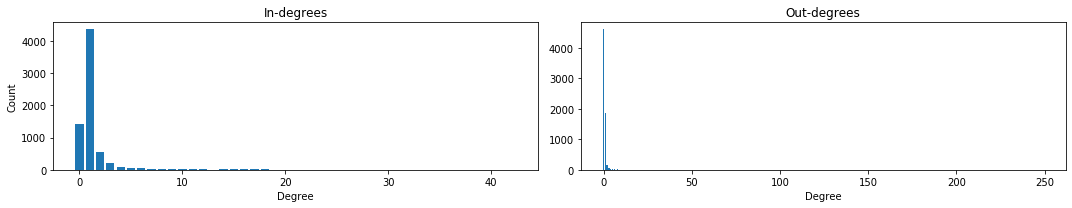

In [11]:
plt.figure(figsize=[15,3])
plt.subplot(121)
hist = np.histogram(degree_in,bins=max(degree_in));
plt.bar(hist[1][0:max(degree_in)],hist[0]);
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('In-degrees');


plt.subplot(122)
hist = np.histogram(degree_out,bins=max(degree_out));
plt.bar(hist[1][0:max(degree_out)],hist[0]);
plt.title('Out-degrees');
plt.xlabel('Degree')
plt.tight_layout()

#plt.savefig('DegreeDistributions_actual.png')
plt.show()

In well accordens with what was found before the medians are found to be 1 and 0 for the in- and out-degrees, respectively, showing that most artists are only little linked to their fellow artists. 

The out-degree distribution have a far larger variance than that of the in-degree distribution, again underlying that it is more popular for collaborating artists to invite other artists to their own songs - the creative hospitality is apparently quite large!

Furthermore, the right-skewness of the these ditributions, i.e. occurence of many little connected nodes combined with a few very connected nodes (hubs), is a good indication that the network indeed is a real network.

To see if the network behaves more in a random or a scale-free manner it was investigated whether the distribution follow a poisson distribution, and hence have a random character (Erdos-Renyi network), or they follow a power-law, and hence have a scale-free character (Barabasi-Albert network). As stated, the actual scaled histrograms above do not reallt showcase a nice poisson distribution. At the other hand, when plotted on log-log axes, the below histograms are found, which could look like to be in compliance with the power-law:

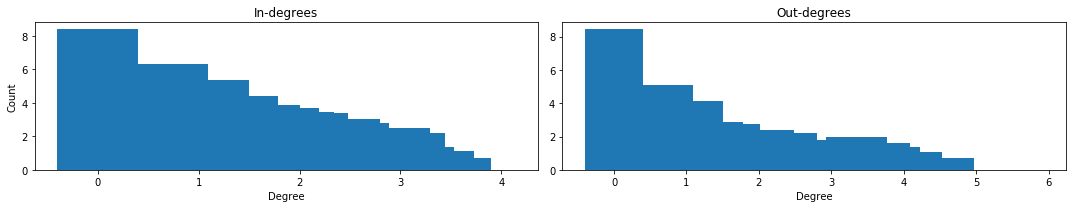

In [12]:
plt.figure(figsize=[15,3])
plt.subplot(121)
hist = np.histogram(degree_in,bins=max(degree_in));
plt.bar(np.ma.log(hist[1][0:max(degree_in)]).filled(0),np.ma.log(hist[0]).filled(0));
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('In-degrees');


plt.subplot(122)
hist = np.histogram(degree_out,bins=max(degree_out));
plt.bar(np.ma.log(hist[1][0:max(degree_out)]).filled(0),np.ma.log(hist[0]).filled(0));
plt.xlabel('Degree')
plt.title('Out-degrees');
plt.tight_layout()
#plt.savefig('DegreeDistributions_loglog.png')
plt.show()

The apparent scale-free behaviour, consistent with a real-type network, was then further investigated through the friendship paradox which indicates the occurence of lots of hubs when true. However, as seen below most nodes do not follow the frienship paradox. 

In [13]:
FP_True = 0
for i in range(1000):
    # Pick a node i at random (e.g. use random.choice). 
    rand_node_i = random.choice(list(G.nodes()))
    # Find its degree.
    k_i = G.degree[rand_node_i] 
    # Find i's neighbors.
    i_neighbors = list(G.neighbors(rand_node_i))
    # And calculate their average degree.
    k_i_neighbors = np.mean([G.degree[j] for j in i_neighbors])
    
    if k_i_neighbors > k_i:
        FP_True += 1

print(str(FP_True) + ' time out of the 1000 is the paradox true.')

296 time out of the 1000 is the paradox true.


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Lastly, it was investigated whether any correlations could be found between the in- and out-degrees. However, as seen from the scatter-plot below, there does generally not seem to be any such correlations.

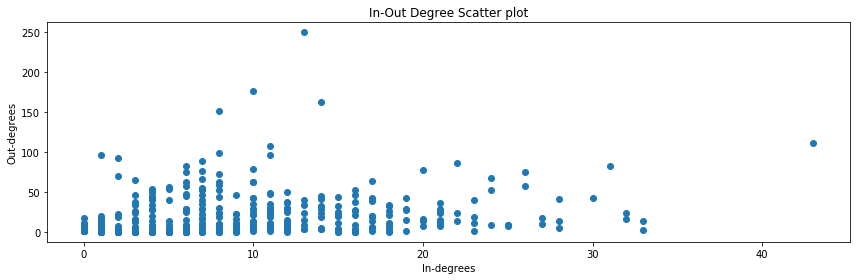

In [14]:
plt.figure(figsize=[12,4])
plt.scatter(degree_in,degree_out);
plt.title('In-Out Degree Scatter plot')
plt.xlabel('In-degrees'); 
plt.ylabel('Out-degrees');
plt.tight_layout()
#plt.savefig('InOutScatter.png')
plt.show()

### Paths in the network

The five analyzed nodes or artists, i.e. "San Quinn","Too $hort","Gucci Mane","Major Lazer","Pitbull", are the nodes with the highest degrees. To get an idea of how close these artists are to each other, the shortest path length between them is calculated:

In [15]:
artists = ["San Quinn","Too $hort","Gucci Mane","Major Lazer","Pitbull"]

for i in artists:
    for k in artists:
        if i != k:
            print(i,' --> ',k,' : ',nx.shortest_path_length(G, source = i, target = k))
        else:
            continue

San Quinn  -->  Too $hort  :  2
San Quinn  -->  Gucci Mane  :  1
San Quinn  -->  Major Lazer  :  3
San Quinn  -->  Pitbull  :  2
Too $hort  -->  San Quinn  :  1
Too $hort  -->  Gucci Mane  :  2
Too $hort  -->  Major Lazer  :  3
Too $hort  -->  Pitbull  :  2
Gucci Mane  -->  San Quinn  :  3
Gucci Mane  -->  Too $hort  :  2
Gucci Mane  -->  Major Lazer  :  2
Gucci Mane  -->  Pitbull  :  2
Major Lazer  -->  San Quinn  :  4
Major Lazer  -->  Too $hort  :  3
Major Lazer  -->  Gucci Mane  :  2
Major Lazer  -->  Pitbull  :  2
Pitbull  -->  San Quinn  :  3
Pitbull  -->  Too $hort  :  2
Pitbull  -->  Gucci Mane  :  2
Pitbull  -->  Major Lazer  :  2


The reason that the path lengths between the same two nodes but in opposite directions isn't necessarily the same is that the graph is directed which might forces detours into one of the directions compared with the other. 

Compared with the average shortest path length for the overall network, these values might seem longer, however, when compared with a node having a low degree, for instance the artist 'Cadet' which only have a degree of 3, where the shortest path length to e.g. 'San Quinn' is 6 it is evident that the high degree of the selected nodes is shortening the pathe lengths.

In [16]:
print('Average shortest path length: ',nx.average_shortest_path_length(G))
print('Cadet',' --> ','San Quinn',' : ',nx.shortest_path_length(G, source = 'Cadet', target = "San Quinn"))

Average shortest path length:  1.4183614403767049
Cadet  -->  San Quinn  :  6


### Centrality analysis

Another extremely important and useful tool when analysing networks, is to calculate the centralities of various nodes. In broad terms the centrality, which can be calculated in various ways, is a measure of how imporant a given node is in the network. In the following the centralities will both be assessed through degree, betweeness and eigenvector centralities.

In [18]:
#The the graph is first prepared for analysis by finding the weakly connected component subgraphs
Gc = max(nx.weakly_connected_component_subgraphs(G),key=len)

Betweeness centrality is a measure of how many times the shortest path between two nodes pass through the node in question. This is therefore an indication of the relative importance of a given node for the connectivity of the network.

Eigenvector centrality measures the importance of nodes according to relative scores that are based on how connected the node in question is to other high scoring nodes. This "importancy measurement" is therefore in indication of high a node is in the social hierarchy.

The most simple centrality measurements are the in- and out-degree centralitiesm which is the fraction of nodes that the edges of the node in question is connected to. These are normalized according to the maximum possible degree. These measurements merely say something about which artists that collaborate the most.

Below is the top-10 high-scoring the nodes according to these different centrality measurements plotted.

In [19]:
BetweennessCentrality = sorted(nx.betweenness_centrality(Gc).items())
EigenvectorCentrality = sorted(nx.eigenvector_centrality(Gc).items())

In [20]:
InDegreeCentrality = sorted(nx.in_degree_centrality(Gc).items())
OutDegreeCentrality = sorted(nx.out_degree_centrality(Gc).items())

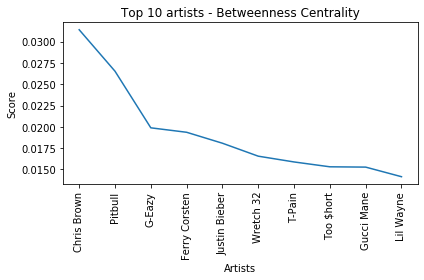

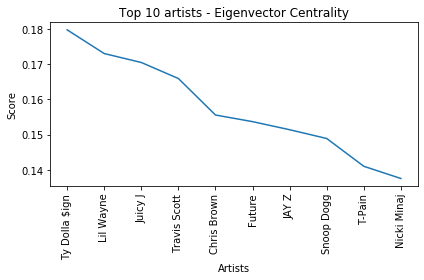

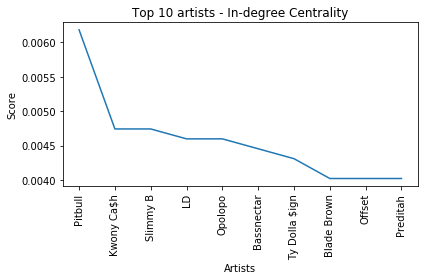

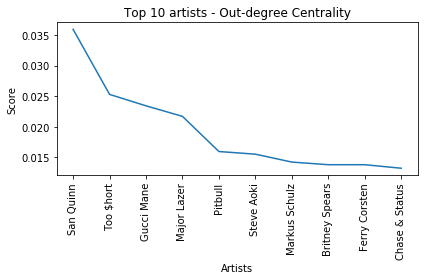

In [21]:
lists = sorted(BetweennessCentrality,key=lambda kv: kv[1],reverse=True)[:10]
x, y = zip(*lists) # unpack a list of pairs into two tuples

x = x[:10]
y = y[:10]


plt.plot(x,y)
plt.ylabel('Score')
plt.xlabel('Artists')
plt.title('Top 10 artists - Betweenness Centrality')
plt.xticks(x, rotation='vertical')
plt.tight_layout()
plt.savefig('betweenness_centrality.png')
plt.show()

lists = sorted(EigenvectorCentrality,key=lambda kv: kv[1],reverse=True)[:10]
x, y = zip(*lists) # unpack a list of pairs into two tuples

x = x[:10]
y = y[:10]


plt.plot(x,y)
plt.ylabel('Score')
plt.xlabel('Artists')
plt.title('Top 10 artists - Eigenvector Centrality')
plt.xticks(x, rotation='vertical')
plt.tight_layout()
plt.savefig('Eigenvector_centrality.png')
plt.show()

lists = sorted(InDegreeCentrality,key=lambda kv: kv[1],reverse=True)[:10]
x, y = zip(*lists) # unpack a list of pairs into two tuples

x = x[:10]
y = y[:10]


plt.plot(x,y)
plt.ylabel('Score')
plt.xlabel('Artists')
plt.title('Top 10 artists - In-degree Centrality')
plt.xticks(x, rotation='vertical')
plt.tight_layout()
plt.savefig('InDegree_centrality.png')
plt.show()
           
lists = sorted(OutDegreeCentrality,key=lambda kv: kv[1],reverse=True)[:10]
x, y = zip(*lists) # unpack a list of pairs into two tuples

x = x[:10]
y = y[:10]

plt.plot(x,y)
plt.ylabel('Score')
plt.xlabel('Artists')
plt.title('Top 10 artists - Out-degree Centrality')
plt.xticks(x, rotation='vertical')
plt.tight_layout()
plt.savefig('OutDegree_centrality.png')
plt.show()

Even though a lot of artists are found multiple of these importancy measurements it is worth noting that different nodes have different importancies.

## Audio analysis

The below code is the spotify api called to retreive 9 audio features for 5 selected songs from each of the 5 artists. For each artists an average value of the audio features based on the 5 songs, is calculated.

An explanation of the 9 audio features selected are found through this link: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

In [24]:
CLIENT_ID = "4688af49fa6d44888e1e9efc433c05c8"
CLIENT_SECRET = "88271e39c3504fd99f599872c748ea73"

credentials = oauth2.SpotifyClientCredentials(client_id=CLIENT_ID,client_secret=CLIENT_SECRET)

token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

def GetFeatureList(track_list):
    dancability = 0
    energy = 0
    key = 0
    loudness = 0
    speechiness = 0
    acousticness = 0
    instrumentalness = 0
    liveness = 0
    tempo = 0

    feature_list = []

    #loop over de fem sange
    for i in track_list:
        res = spotify.search(i, type='track')
        art_id = res['tracks']['items'][0]['id']

        audio_features = spotify.audio_features(art_id)

        dancability += audio_features[0]['danceability']
        energy += audio_features[0]['energy']
        key += audio_features[0]['key']
        loudness += audio_features[0]['loudness']
        speechiness += audio_features[0]['speechiness']
        acousticness += audio_features[0]['acousticness']
        instrumentalness += audio_features[0]['instrumentalness']
        liveness += audio_features[0]['liveness']
        tempo += audio_features[0]['tempo']

    dancability_avg = dancability/len(track_list)
    energy_avg = energy/len(track_list)
    key_avg = key/len(track_list)
    loudness_avg = loudness/len(track_list)
    speechiness_avg = speechiness/len(track_list)
    acousticness_avg = acousticness/len(track_list)
    instrumentalness_avg = instrumentalness/len(track_list)
    liveness_avg = liveness/len(track_list)
    tempo_avg = tempo/len(track_list)

    feature_list.append([dancability_avg,energy_avg,key_avg,loudness_avg,speechiness_avg,acousticness_avg,instrumentalness_avg,liveness_avg,tempo_avg])
    return feature_list

SanQuin_track_list = ['Paid (feat. Los Rakas)','Hell Yeah','Pop Ya Collar',"Ain't Nobody Thuggin'",'City Boi']
TooShort_track_list = ['10 Bad Bitches (feat. Stressmatic)','16 Hoes - Main Version - Explicit','19,999','2 Bitches',"It's About That Money (feat. P. Diddy)"]
GucciMane_track_list = ['100 Bails Of Kush','100 Grand','1017 Mafia','15 Minutes Past the Diamond','16 Fever']
MajorLazer_track_list = ['Lean On','Evapora','Cold Water','Trigger','Watch Out For This - Daddy Yankee Remix']
Pitbull_track_list = ['Give Me Everything','Time of Our Lives','Hotel Room Service','International Love','I Know You Want Me (Calle Ocho)']

SanQuin_feauture_list = GetFeatureList(SanQuin_track_list)
TooShort_feauture_list = GetFeatureList(TooShort_track_list)
GucciMane_feauture_list = GetFeatureList(GucciMane_track_list)
MajorLazer_feauture_list = GetFeatureList(MajorLazer_track_list)
Pitbull_feauture_list = GetFeatureList(Pitbull_track_list)

all_lists = [SanQuin_feauture_list,TooShort_feauture_list,GucciMane_feauture_list,MajorLazer_feauture_list,Pitbull_feauture_list]

To be able to plot the audio features in the same plot as well as ease the comparison between the individual artists, the actual values for each feature is converted to standard scores:

In [25]:
def standardization(lis):
    #Calculate the standard score
    lis_stand = []
    mean = np.mean(lis)
    std = np.std(lis)
    
    for i in lis:
        lis_stand.append((i-mean)/std)
    return lis_stand

dancability_all = []
energy_all = []
key_all = []
loudness_all = []
speechiness_all = []
acousticness_all = []
instrumentalness_all = []
liveness_all = []
tempo_all = []

for idx in range(len(all_lists)):
    dancability_all.append(all_lists[idx][0][0])
    energy_all.append(all_lists[idx][0][1])
    key_all.append(all_lists[idx][0][2])
    loudness_all.append(all_lists[idx][0][3])
    speechiness_all.append(all_lists[idx][0][4])
    acousticness_all.append(all_lists[idx][0][5])
    instrumentalness_all.append(all_lists[idx][0][6])
    liveness_all.append(all_lists[idx][0][7])
    tempo_all.append(all_lists[idx][0][8])
    
dancability_stand = standardization(dancability_all)
energy_stand = standardization(energy_all)
key_stand = standardization(key_all)
loudness_stand = standardization(loudness_all)
speechiness_stand = standardization(speechiness_all)
acousticness_stand = standardization(acousticness_all)
instrumentalness_stand = standardization(instrumentalness_all)
liveness_stand = standardization(liveness_all)
tempo_stand = standardization(tempo_all)

Plotting the standard scores ...

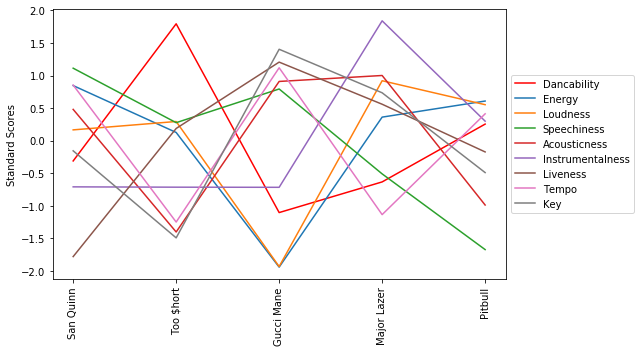

In [26]:
x = ['San Quinn','Too $hort','Gucci Mane', 'Major Lazer', 'Pitbull']
plt.figure(figsize=[9,5])
plt.plot(x, dancability_stand, 'r')  
plt.plot(x, energy_stand) 
plt.plot(x, loudness_stand)
plt.plot(x, speechiness_stand)
plt.plot(x, acousticness_stand)
plt.plot(x, instrumentalness_stand)
plt.plot(x, liveness_stand)
plt.plot(x, tempo_stand)
plt.plot(x, key_stand)
plt.xticks(x, rotation = 'vertical')
plt.ylabel('Standard Scores')
plt.legend(['Dancability', 'Energy','Loudness','Speechiness','Acousticness','Instrumentalness','Liveness','Tempo','Key'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('AudioFeatures.png')
plt.show()

To have been able to identify whether the 5 selected artists have any audio features that are make these artists stand out from the crowd, the average values for each feature should have been calculated. Optionally, could a assortativity analysis have been made by finding the assortativity coefficients for each node. However, these things would have required that the audio feautures should have been found for all 7000 nodes and for 5 songs for each. This was quickly realized as being too heavy to calculate.

Since we are comparing the 5 artists among eachother, each of the features have been converted to standard scores. This also means that a high or low standard score don't necessarily mean that the actual feature values are significantly high or low, just the lowest of the compared artist. This is for instance seen from the accousticness which is quite high for Gucci Mane and Major Lazer, both artists that are not particularly recognized for making accoustic music.

However, when looking at a feature like speechiness, it can clearly be seen that the first three artists in the plot is recognized as rappers while the latter two artist are scoring higher in instrumentalness in sync with the electronic music that these are known for. 

# Spotify API 

Spotify Api called spotipy is used to extract data from Spotify.


Furthermore the https://spotipy.readthedocs.io/en/latest/ is used to find the function calls to get the data. 
as well as the https://github.com/plamere/spotipy


In [ ]:
import os

import sys

import json

import spotipy

import webbrowser

import spotipy.util as util

from spotipy.oauth2 import SpotifyClientCredentials #To access authorised Spotify data


username = sys.argv[1]

#USER ID marialyck?si=ORIrwCGTTO6sLdJVsE_zLw

client_id = CLIENT_ID

client_secret = CLIENT_SECRET

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API


# Lyrics Genoius API

For the lyrics the geniuos API was used

The Genious Lyrics API is used to obtain the 5 lyrics texts 

More info on the API can be obtained at:
https://github.com/johnwmillr/LyricsGenius


In [40]:
import operator
SingerArray = ["San Quinn","Too $hort","Gucci Mane","Major Lazer","Pitbull"]


genius = lyricsgenius.Genius("TKp5Auidd8l-XbwgNBCBYmgsouYCfliG9BO4KvKE4ZjU2XF99qL66GU2_UgCxP2r")

songList = 0
listarray = []
while songList < 5:
    #Generating five songs from the five most connected (featuring) artists
    artist = genius.search_artist(SingerArray[songList], max_songs=5, sort="title")
    lst = artist.songs
    

    listarray.append(artist.songs)

    #print(listarray)
    
    songList += 1

    
print(listarray)   
f = open("5_songs.txt","w+")
f.write(str(listarray))
f.close() 

Searching for songs by San Quinn...

Song 1: "Drunk in San Francisco"
Song 2: "Hell Yeah"
Song 3: "Intro"
Song 4: "Northern California"
Song 5: "Playin’ By The Rules"

Reached user-specified song limit (5).
Done. Found 5 songs.
Searching for songs by Too $hort...

Song 1: "10 Bad Bitches"
Song 2: "16 Hoes"
Song 3: "19,999"
Song 4: "2 Bitches"
Song 5: "About That Money (P. Diddy Outro)"

Reached user-specified song limit (5).
Done. Found 5 songs.
Searching for songs by Gucci Mane...

Song 1: "100 Bails Of Kush"
Song 2: "100 Grand"
Song 3: "1017 Mafia"
Song 4: "15 Minutes Past the Diamond"
Song 5: "16 Fever"

Reached user-specified song limit (5).
Done. Found 5 songs.
Searching for songs by Major Lazer...

Song 1: "10 Years and Counting..."
Song 2: "2 Cups"
Song 3: "Aerosol Can"
Song 4: "All I Want"
Song 5: "All My Life"

Reached user-specified song limit (5).
Done. Found 5 songs.
Searching for songs by Pitbull...

Song 1: "11:59"
Song 2: "305 Anthem"
Song 3: "3 to Tango"
Song 4: "Across

In [41]:
#Since the format the list from Genious came in caused a bit of trouble and since time was limited
#This part was solved in a rather manual way:
singername0 = SingerArray[0]
song1 = genius.search_song("Drunk in San Francisco", singername0)
song2 = genius.search_song("Hell Yeah", singername0)
song3 = genius.search_song("Intro", singername0)
song4 = genius.search_song("Northern California",singername0)
song5 = genius.search_song("Playin’ By The Rules", singername0)

singername1 = SingerArray[1]
song6 = genius.search_song("10 Bad Bitches", singername1)
song7 = genius.search_song("16 Hoes", singername1)
song8 = genius.search_song("19,999", singername1)
song9 = genius.search_song("2 Bitches", singername1)
song10 = genius.search_song("About That Money (P. Diddy Outro)", singername1)

singername2 = SingerArray[2]
song11 = genius.search_song("100 Bails Of Kush", singername2)
song12 = genius.search_song("100 Grand", singername2)
song13 = genius.search_song("1017 Mafia", singername2)
song14 = genius.search_song("15 Minutes Past the Diamond", singername2)
song15 = genius.search_song("16 Fever", singername2)

singername3 = SingerArray[3]
song16 = genius.search_song("10 Years and Counting...", singername3)
song17 = genius.search_song("2 Cups", singername3)
song18 = genius.search_song("Aerosol Can", singername3)
song19 = genius.search_song("All I Want", singername3)
song20 = genius.search_song("All My Life", singername3)

singername4 = SingerArray[4]
song21 = genius.search_song("11:59", singername4)
song22 = genius.search_song("305 Anthem", singername4)
song23 = genius.search_song("3 to Tango", singername4)
song24 = genius.search_song("Across the World", singername4)
song25 = genius.search_song("Africa", singername4)



Searching for "Drunk in San Francisco" by San Quinn...
Done.
Searching for "Hell Yeah" by San Quinn...
Done.
Searching for "Intro" by San Quinn...
Done.
Searching for "Northern California" by San Quinn...
Done.
Searching for "Playin’ By The Rules" by San Quinn...
Done.
Searching for "10 Bad Bitches" by Too $hort...
Done.
Searching for "16 Hoes" by Too $hort...
Done.
Searching for "19,999" by Too $hort...
Done.
Searching for "2 Bitches" by Too $hort...
Done.
Searching for "About That Money (P. Diddy Outro)" by Too $hort...
Done.
Searching for "100 Bails Of Kush" by Gucci Mane...
Done.
Searching for "100 Grand" by Gucci Mane...
Done.
Searching for "1017 Mafia" by Gucci Mane...
Done.
Searching for "15 Minutes Past the Diamond" by Gucci Mane...
Done.
Searching for "16 Fever" by Gucci Mane...
Done.
Searching for "10 Years and Counting..." by Major Lazer...
Done.
Searching for "2 Cups" by Major Lazer...
Done.
Searching for "Aerosol Can" by Major Lazer...
Done.
Searching for "All I Want" by M

In [44]:
#Create txt files - ready to be analysed and to be put into the github repo for the user to have data to play with
singercounter = 0
while singercounter < 5:
    f = open(SingerArray[singercounter]+".txt","w+")
    if singercounter == 0:
        f.write(song1.lyrics + "\n" + song2.lyrics + "\n" + song3.lyrics + "\n" + song4.lyrics + "\n" + song5.lyrics)
    elif singercounter == 1:
        f.write(song6.lyrics + "\n" + song7.lyrics + "\n" + song8.lyrics + "\n" + song9.lyrics + "\n" + song10.lyrics)
    elif singercounter == 2:
        f.write(song11.lyrics + "\n" + song12.lyrics + "\n" + song13.lyrics + "\n" + song14.lyrics + "\n" + song15.lyrics)            
    elif singercounter == 3:
        f.write(song16.lyrics + "\n" + song17.lyrics + "\n" + song18.lyrics + "\n" + song19.lyrics + "\n" + song20.lyrics)            
    elif singercounter == 4:
        f.write(song21.lyrics + "\n" + song22.lyrics + "\n" + song23.lyrics + "\n" + song24.lyrics + "\n" + song25.lyrics)            
    f.close()
    singercounter += 1

# Lyrics analysist
In order to understand our artists and what makes them so popular that so many wants to work with them we look into both the used language in their songs as well as what others have written about them at the Wikipedia.

The first part is using the Genius API to collect 5 song's lyrics for the choosen 5 artists. The lyric for each artist are appended into one txt file, which is being open to use the lyric as a string. 

In [46]:
import os, string, math, glob, random, nltk, re
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from PIL import Image
import wikipediaapi
import matplotlib.pyplot as plt

#Reading the top-five artits top five songs lyrics.
pitbull = open('lyric/pitbull.txt', "r")
pitbull_text = pitbull.read()
pitbull.close()

guccimane = open('lyric/guccimane.txt', "r")
guccimane_text = guccimane.read()
guccimane.close()

majorlazer = open('lyric/majorlazer.txt', "r")
majorlazer_text = majorlazer.read()
majorlazer.close()

tooshort = open('lyric/tooshort.txt', "r")
tooshort_text = tooshort.read()
tooshort.close()

sanquinn = open('lyric/sanquinn.txt', "r")
sanquinn_text = sanquinn.read()
sanquinn.close()

Next part is to prepare the data for cleaning. A function is made that enable a given string remove sqaure brackets, which is being used in the lyrics to describe which verse it is and who is singing that specific verse. This information is not relevant and might twist the result. This function is then being applyed to all 5 text files containing lyrics.

In [47]:
#Creating a list with stopwords
stopwords = list(stopwords.words('english'))

#Adding custom words from lyrics which is not intended. 
newwords = ['Chorus', 'Verse', 'Intro', 'Pre-Chorus', 'Refrain', 'Outro']
for i in newwords:
    stopwords.append(i)
def removeverseinfo(text):
    brakets = r"\[.*?\]"
    text = re.sub(brakets, "", text)
    result = ''.join(text)
    return result

pitbull_text = removeverseinfo(pitbull_text)
guccimane_text = removeverseinfo(guccimane_text)
majorlazer_text = removeverseinfo(majorlazer_text)
tooshort_text = removeverseinfo(tooshort_text)
sanquinn_text = removeverseinfo(sanquinn_text)

Next up is to remove punctuation, this removes all unwanted signs. Also, a regular expression is being used to only keep letters from the alphabet (a-z). This is to make sure only letters are being keept and everything else is removed, to be able to analyze the wanted text. Stopwords are also removed, due to that these words are not interesting for the analysis, due to that they might show repeatedly through out the different text documents. All of this is made into a function which can easily be applied to all the 5 texts (lyrics and Wikipedia pages). 

In [48]:
#Function which cleans the data. Makes all letters lower and removing stopwords.
num_pat = r"[a-z]+"

def cleaning(def_string):
    def_string = def_string.lower()
    def_string = re.findall(num_pat, def_string)
    #def_string = [w for w in def_string if w.strip()]
    def_string = [w for w in def_string if not w in stopwords]
    result = ' '.join(def_string)
    return result

Applying the function to all 5 texts.

In [49]:
#Applying function cleaning to each cleaned textfile.
pitbull_split = cleaning(pitbull_text).split(" ")

guccimane_split = cleaning(guccimane_text).split(" ")

majorlazer_split = cleaning(majorlazer_text).split(" ")

tooshort_split = cleaning(tooshort_text).split(" ")

sanquinn_split = cleaning(sanquinn_text).split(" ")



In order to peform the TF-IDF it is wanted to create a word dictionary for each artist based on how many times words appears in their lyrics. 

First a set is created to combine all words which appears in all 5 artists' 5 songs.

In [50]:
#Creating a set of all words which appears in all five artits' five songs.
artist_list = [guccimane_split, majorlazer_split, sanquinn_split, pitbull_split, tooshort_split]
wordSet = set().union(*artist_list)

Next each dictionary is initialized with all the given words from the previously made set of words, all words are keys and all values are set to 0 as a counter.

Then for each artist, all words in the text are being loop-through and for each words appearing the counter is adding 1 to the given value in the dictionary. 

In [51]:
#Creating dictionary to count how many times a word appears in the lyric file.
guccimane_wordDict = dict.fromkeys(wordSet, 0)
majorlazer_wordDict = dict.fromkeys(wordSet, 0)
sanquinn_wordDict = dict.fromkeys(wordSet, 0)
pitbull_wordDict = dict.fromkeys(wordSet, 0)
tooshort_wordDict = dict.fromkeys(wordSet, 0)

#Counting each words in Gucci Mane file.
for w in guccimane_split:
    guccimane_wordDict[w] += 1
    
#Counting each words in mMjor Lazer file.
for w in majorlazer_split:
    majorlazer_wordDict[w] += 1

#Counting each words in San Quinn file.
for w in sanquinn_split:
    sanquinn_wordDict[w] += 1
    
#Counting each words in Pitbull file.
for w in pitbull_split:
    pitbull_wordDict[w] += 1
    
#Counting each words in Too $short file.
for w in tooshort_split:
    tooshort_wordDict[w] += 1

TF-IDF is a two calculations, so to begin with, TF is being calculated.

$TF = \frac{number \:word \:appears \:in \:corpus}{total \:number \:of \:words \:in \:corpus}$

This gives a value which represents the fraction of a specific word within the corpus.
A value will be calculated for each artist lyrics.

Ref: (http://www.tfidf.com/)

In [12]:
#Function which calculate the TF (Term frequency)
def calculateTF(wordDict, split):
    tfDict = {}
    splitCount = len(split)
    for w, count in wordDict.items():
        tfDict[w] = count / float(splitCount)
    return tfDict

In [13]:
#TF is being applied to each file for the 5 selected artists.
guccimane_tfSplit = calculateTF(guccimane_wordDict, guccimane_split)
majorlazer_tfSplit = calculateTF(majorlazer_wordDict, majorlazer_split)
sanquinn_tfSplit = calculateTF(sanquinn_wordDict, sanquinn_split)
pitbull_tfSplit = calculateTF(pitbull_wordDict, pitbull_split)
tooshort_tfSplit = calculateTF(tooshort_wordDict, tooshort_split)

IDF is the inverse document frequency, which is a term for how 'rare' a word is compared to other corpus'. 

This can be translated into, that if we compare two corpus' there might be words which only are represented in one of the texts and therefor it will get a higher score. If words appears in all five corpus' texts it will give that word a low score or even 0.

This is how IDF is calculated:


$IDF = log(\frac{number \:of \:documents(corpus')}{number \:of \:corpus \:which \:contains \:a \:word})$

Ref: (http://www.tfidf.com/)

In [14]:
#Calculating IDF based on equation above. 
def calculateIDF(docList):
    idfDict = {}
    N = len(docList)
    
    idfDict = dict.fromkeys(docList[0].keys(),0)
    for doc in docList:
        for w, val in doc.items():
            if val > 0:
                idfDict[w] += 1

    for w, val in idfDict.items():
        idfDict[w] = math.log(N / float(val))

    return idfDict

IDF is then calculated with all previously made dictionaries. All dictionaries are being applied into the function which calculates the IDF. This will give an score which is later being used to calculate the TF-IDF.

In [15]:
#Creating idfs with artist's dictionary
idfs = calculateIDF([guccimane_wordDict, 
                     majorlazer_wordDict, 
                     sanquinn_wordDict, 
                     pitbull_wordDict, 
                     tooshort_wordDict])



Then we can calculate the TF-IFD.

It is done by following eqaution:

Just multiplying both results from TF and IDF.

$TF-IDF = TF * IDF$

This will create a dictionary with all words for each artist and then a given value which representes how important that given word is based on ranking. This is based on if the words only appears in one text and how many times it is meantioned within a given corpus.

Ref: (http://www.tfidf.com/)

In [16]:
#Function which calculate the TF-IDF
def calculateTFIDF(tfSplit, idfs):
    tfidf = {}
    for w, val in tfSplit.items():
        tfidf[w] = val * idfs[w]
    return tfidf

TF-IDF is calculated for each artist.

In [17]:
#Applying TFIDF to each artist corpus (lyrics)
guccimane_tfidf = calculateTFIDF(guccimane_tfSplit, idfs)
majorlazer_tfidf = calculateTFIDF(majorlazer_tfSplit, idfs)
sanquinn_tfidf = calculateTFIDF(sanquinn_tfSplit, idfs)
pitbull_tfidf = calculateTFIDF(pitbull_tfSplit, idfs)
tooshort_tfidf = calculateTFIDF(tooshort_tfSplit, idfs)


These two functions are made to create nuances of the same color which can be used to decorate the wordclouds. These two functions will output different types of both blue and red.

In [18]:
#Functions to give wordclouds colors. This is used to differ between lyrics and Wikipedia.
def color_lyric(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 5.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

def color_wiki(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 155.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

The dictionary created from the TF-IDF with the ranked values for the words in the respective corpus' are then being visually illustrated by a wordcloud. The wordcloud represent the words which are ranked the highest from the TF-IDF calculation, and the higher the score is, the larger the word is represented. The color for the lyrics are red, just to make it easy to differ bewteen lyrics and Wikipedia wordclouds.

It has been choosen to include a maximum of 100 words.

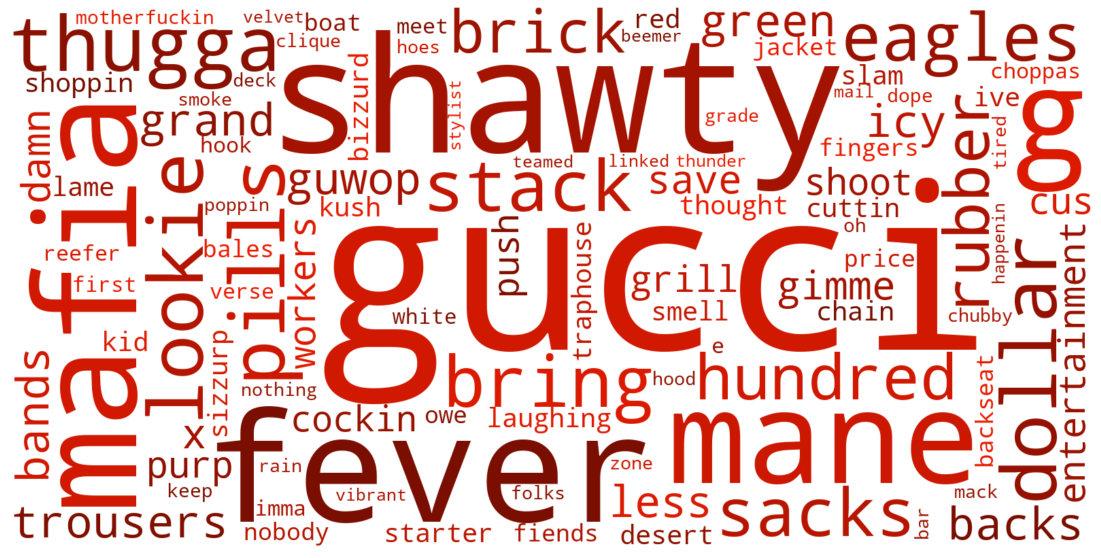

<Figure size 432x288 with 0 Axes>

In [28]:
#Plotting a wordcloud on lyrics for Gucci Mane lyrics.
guccimane_wordcloud = WordCloud(background_color="white", 
                                max_words = 100, 
                                contour_color = 'firebrick',
                                color_func = color_lyric,
                                height = 800, 
                                width = 1600)

guccimane_wordcloud.generate_from_frequencies(guccimane_tfidf)

plt.figure( figsize=(20,10))
plt.imshow(guccimane_wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('guccimane_wordcloud_lyrics.png')
plt.show()

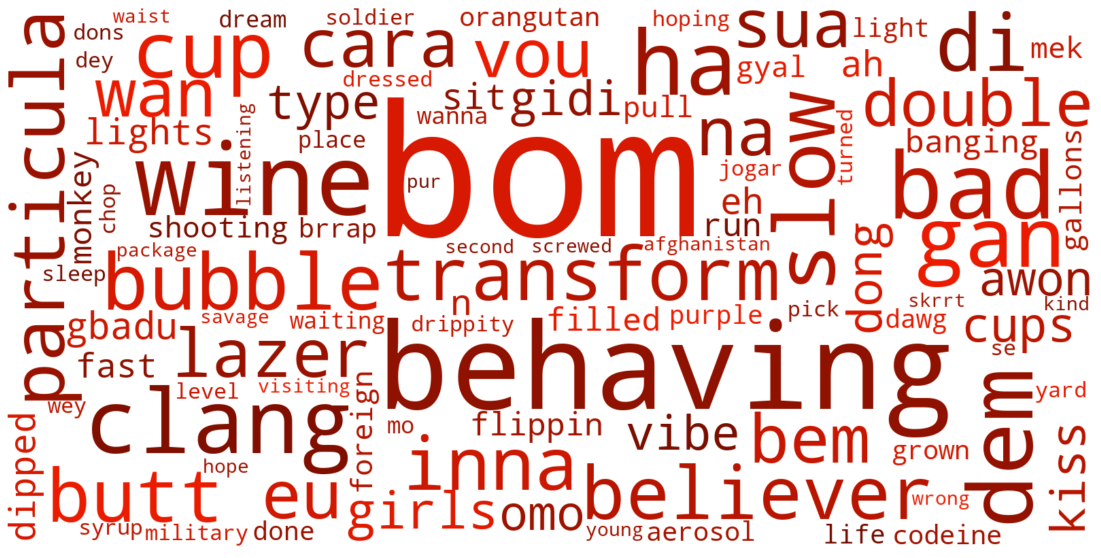

<Figure size 432x288 with 0 Axes>

In [29]:
#Plotting a wordcloud on lyrics for Major Lazer lyrics.
majorlazer_wordcloud = WordCloud(background_color="white", 
                                max_words = 100, 
                                contour_color = 'firebrick',
                                color_func = color_lyric,
                                height = 800, 
                                width = 1600)

majorlazer_wordcloud.generate_from_frequencies(majorlazer_tfidf)

plt.figure( figsize=(20,10))
plt.imshow(majorlazer_wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('majorlazer_wordcloud_lyrics.png')
plt.show()

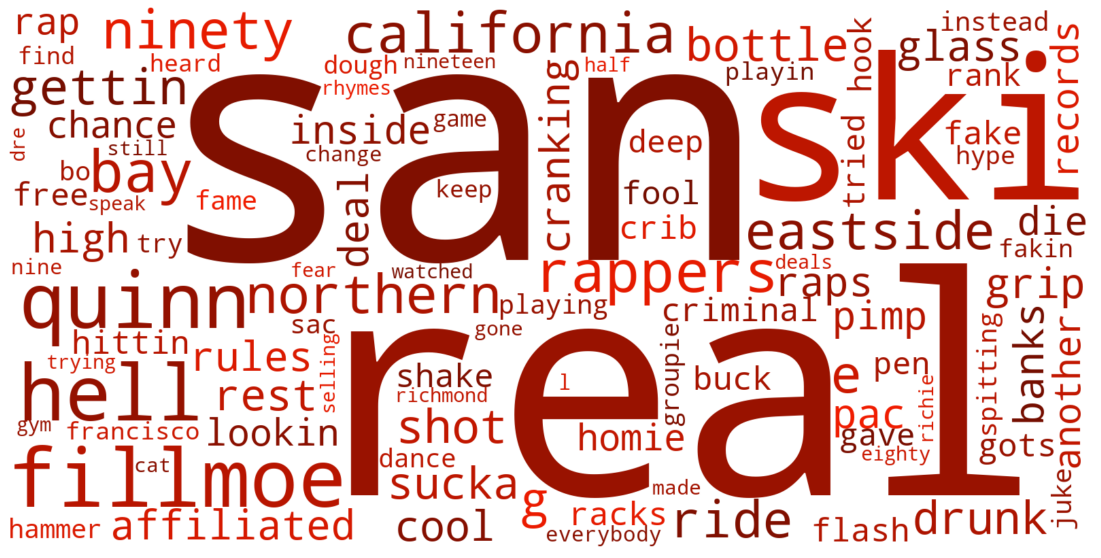

<Figure size 432x288 with 0 Axes>

In [30]:
#Plotting a wordcloud on lyrics for San Quinn lyrics.
sanquinn_wordcloud = WordCloud(background_color="white", 
                                max_words = 100, 
                                contour_color = 'firebrick',
                                color_func = color_lyric,
                                height = 800, 
                                width = 1600)

sanquinn_wordcloud.generate_from_frequencies(sanquinn_tfidf)

plt.figure( figsize=(20,10))
plt.imshow(sanquinn_wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('sanquinn_wordcloud_lyrics.png')
plt.show()

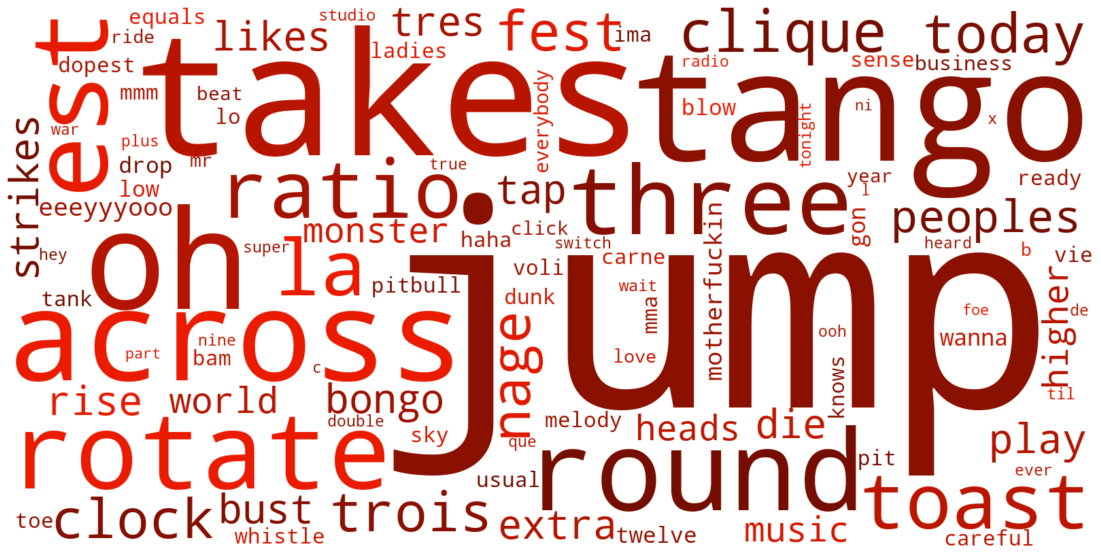

<Figure size 432x288 with 0 Axes>

In [31]:
#Plotting a wordcloud on lyrics for Pitbull lyrics.
pitbull_wordcloud = WordCloud(background_color="white", 
                                max_words = 100, 
                                contour_color = 'firebrick',
                                color_func = color_lyric,
                                height = 800, 
                                width = 1600)

pitbull_wordcloud.generate_from_frequencies(pitbull_tfidf)

plt.figure( figsize=(20,10))
plt.imshow(pitbull_wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('pitbull_wordcloud_lyrics.png')
plt.show()

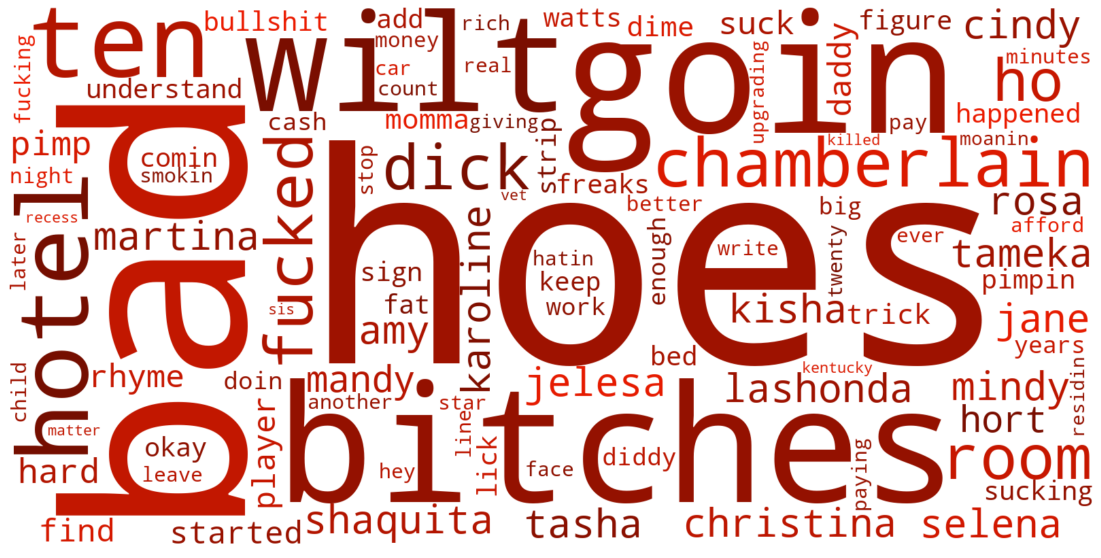

<Figure size 432x288 with 0 Axes>

In [32]:
#Plotting a wordcloud on lyrics for Too $hort lyrics.
tooshort_wordcloud = WordCloud(background_color="white", 
                                max_words = 100, 
                                contour_color = 'firebrick',
                                color_func = color_lyric,
                                height = 800, 
                                width = 1600)

tooshort_wordcloud.generate_from_frequencies(tooshort_tfidf)

plt.figure( figsize=(20,10))
plt.imshow(tooshort_wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('tooshort_wordcloud_lyrics.png')
plt.show()

Next is the analysis of the artist Wikipedia pages. 
To collect the follow information from Wikipedia a Wikipedia API is used.

Ref: (https://pypi.org/project/Wikipedia-API/)

In [19]:
#Settings for Wikipedia API for choosen language, English.
wiki_wiki = wikipediaapi.Wikipedia('en')

Each artist Wikipedia handle are being inserted into the API, to receive the wanted data from calling the API.

The type received from the API is a wikipedia page object, which can be converted into a string, which can easily be cleaned for further analysis. 

For each artist all the text from their Wikipedia pages are then being appended onto a txt file, which can be used for later analysis (sentiment).

In [20]:
#Receive Wikipedia pages.
guccimane_wiki = wiki_wiki.page('Gucci_Mane')
majorlazer_wiki = wiki_wiki.page('Major_Lazer')
sanquinn_wiki = wiki_wiki.page('San_Quinn')
pitbull_wiki = wiki_wiki.page('Pitbull_(rapper)')
tooshort_wiki = wiki_wiki.page('Too_Short')

#Assigning each Wikipedia page to a string.
guccimane_wiki = guccimane_wiki.text
majorlazer_wiki = majorlazer_wiki.text
sanquinn_wiki = sanquinn_wiki.text
pitbull_wiki = pitbull_wiki.text
tooshort_wiki = tooshort_wiki.text

#Writing text into txt files.
guccimane_wiki_file = open("wiki/guccimane.txt", "a")
guccimane_wiki_file.write(guccimane_wiki)
guccimane_wiki_file.close()

majorlazer_wiki_file = open("wiki/majorlazer.txt", "a")
majorlazer_wiki_file.write(majorlazer_wiki)
majorlazer_wiki_file.close()

sanquinn_wiki_file = open("wiki/sanquinn.txt", "a")
sanquinn_wiki_file.write(sanquinn_wiki)
sanquinn_wiki_file.close()

pitbull_wiki_file = open("wiki/pitbull.txt", "a")
pitbull_wiki_file.write(pitbull_wiki)
pitbull_wiki_file.close()

tooshort_wiki_file = open("wiki/tooshort.txt", "a")
tooshort_wiki_file.write(tooshort_wiki)
tooshort_wiki_file.close()

Same function which were used to clean the lyric data is being used on the Wikipedia data.

In [21]:
#Cleaning the wikipedia page data.
pitbull_wiki_split = cleaning(pitbull_wiki).split(" ")

guccimane_wiki_split = cleaning(guccimane_wiki).split(" ")

majorlazer_wiki_split = cleaning(majorlazer_wiki).split(" ")

tooshort_wiki_split = cleaning(tooshort_wiki).split(" ")

sanquinn_wiki_split = cleaning(sanquinn_wiki).split(" ")

TF-IDF is then being calculated with the same process as the lyrics.

In [22]:
#Create a list containing each artist wikipedia pages as a string. 
artist_wiki_list = [guccimane_wiki_split, 
               majorlazer_wiki_split, 
               sanquinn_wiki_split, 
               pitbull_wiki_split, 
               tooshort_wiki_split]

#Make a set of all words that appears in all five wikiepedia pages.
wordSet_wiki = set().union(*artist_wiki_list)

In [23]:
#Creating dictionary to count how many times a word appears in the wikipedia file.
guccimane_wiki_wordDict = dict.fromkeys(wordSet_wiki, 0)
majorlazer_wiki_wordDict = dict.fromkeys(wordSet_wiki, 0)
sanquinn_wiki_wordDict = dict.fromkeys(wordSet_wiki, 0)
pitbull_wiki_wordDict = dict.fromkeys(wordSet_wiki, 0)
tooshort_wiki_wordDict = dict.fromkeys(wordSet_wiki, 0)

#Counting each words in Gucci Mane file.
for w in guccimane_wiki_split:
    guccimane_wiki_wordDict[w] += 1
    
#Counting each words in Major Lazer file.
for w in majorlazer_wiki_split:
    majorlazer_wiki_wordDict[w] += 1

#Counting each words in San Quinn file.
for w in sanquinn_wiki_split:
    sanquinn_wiki_wordDict[w] += 1
    
#Counting each words in Pitbull file.
for w in pitbull_wiki_split:
    pitbull_wiki_wordDict[w] += 1
    
#Counting each words in Too $short file.
for w in tooshort_wiki_split:
    tooshort_wiki_wordDict[w] += 1

In [24]:
#TF is being applied to each file for the 5 selected artists.
guccimane_wiki_tfSplit = calculateTF(guccimane_wiki_wordDict, guccimane_wiki_split)
majorlazer_wiki_tfSplit = calculateTF(majorlazer_wiki_wordDict, majorlazer_wiki_split)
sanquinn_wiki_tfSplit = calculateTF(sanquinn_wiki_wordDict, sanquinn_wiki_split)
pitbull_wiki_tfSplit = calculateTF(pitbull_wiki_wordDict, pitbull_wiki_split)
tooshort_wiki_tfSplit = calculateTF(tooshort_wiki_wordDict, tooshort_wiki_split)

In [25]:
#Calculting IDF based on each artist word dictionary
idfs_wiki = calculateIDF([guccimane_wiki_wordDict, 
                     majorlazer_wiki_wordDict, 
                     sanquinn_wiki_wordDict, 
                     pitbull_wiki_wordDict, 
                     tooshort_wiki_wordDict])

#Applying TFIDF to each artist corpus (Wikipedia)
guccimane_wiki_tfidf = calculateTFIDF(guccimane_wiki_tfSplit, idfs_wiki)
majorlazer_wiki_tfidf = calculateTFIDF(majorlazer_wiki_tfSplit, idfs_wiki)
sanquinn_wiki_tfidf = calculateTFIDF(sanquinn_wiki_tfSplit, idfs_wiki)
pitbull_wiki_tfidf = calculateTFIDF(pitbull_wiki_tfSplit, idfs_wiki)
tooshort_wiki_tfidf = calculateTFIDF(tooshort_wiki_tfSplit, idfs_wiki)

The output from the TF-IDF on the data from the Wikipedia pages are then being used to create a wordcloud. Same settings as the wordcloud based on TF-IDF from lyrics.

Ref: (https://pypi.org/project/wordcloud/)

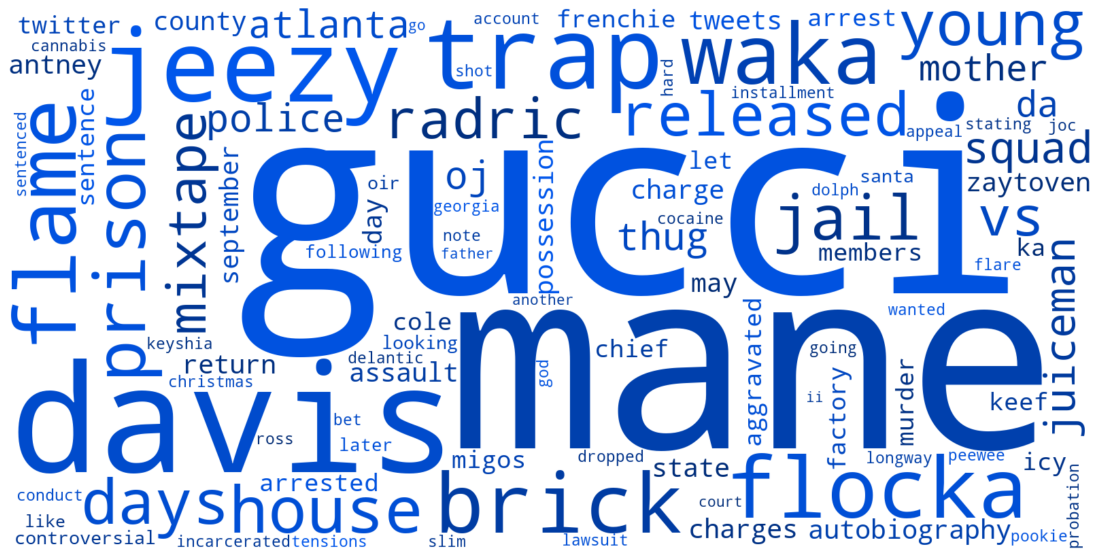

In [29]:
#Plotting a wordcloud on Wikipedia for Gucci Mane.
guccimane_wiki_wordcloud = WordCloud(background_color="white", 
                                max_words = 100, 
                                contour_color = 'firebrick',
                                color_func = color_wiki,
                                height = 800, 
                                width = 1600)

guccimane_wiki_wordcloud.generate_from_frequencies(guccimane_wiki_tfidf)

plt.figure( figsize=(20,10))
plt.imshow(guccimane_wiki_wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('guccimane_wordcloud_wiki.png')
plt.show()

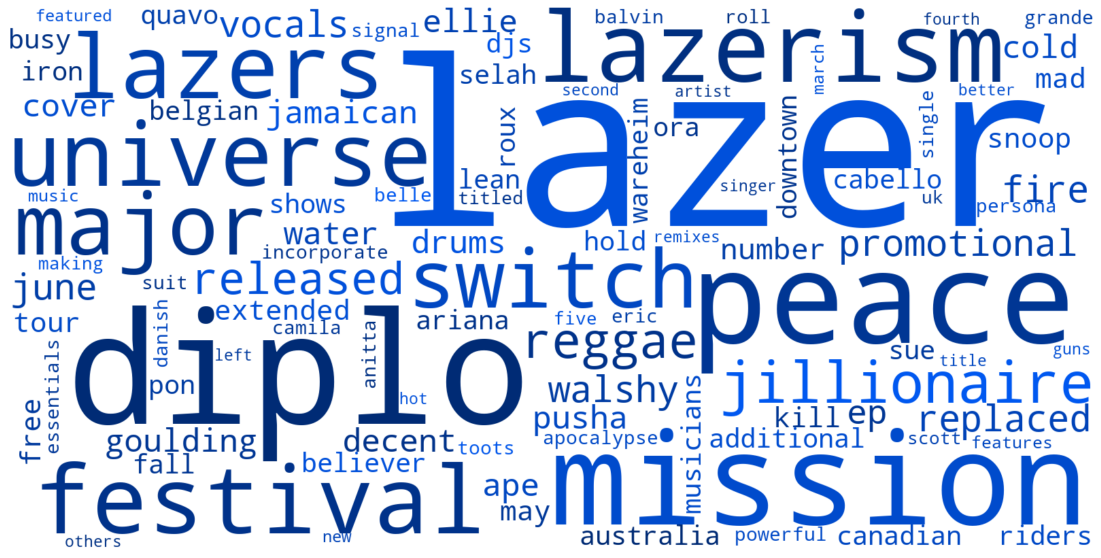

In [30]:
#Plotting a wordcloud on Wikipedia for Major Lazer.
majorlazer_wiki_wordcloud = WordCloud(background_color="white", 
                                max_words = 100, 
                                contour_color = 'firebrick',
                                color_func = color_wiki,
                                height = 800, 
                                width = 1600)

majorlazer_wiki_wordcloud.generate_from_frequencies(majorlazer_wiki_tfidf)

plt.figure( figsize=(20,10))
plt.imshow(majorlazer_wiki_wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('majorlazer_wordcloud_wiki.png')
plt.show()

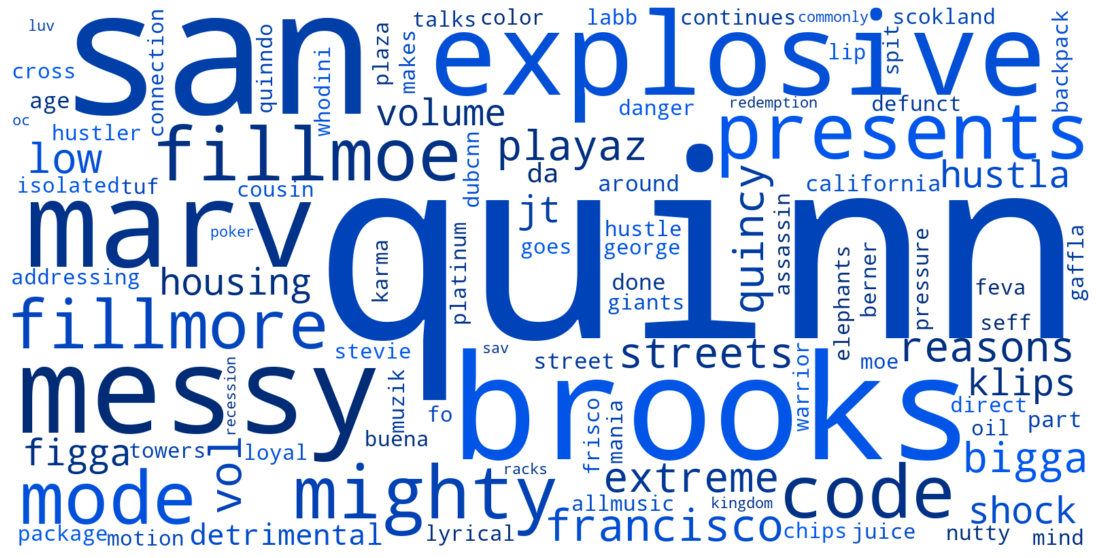

In [31]:
#Plotting a wordcloud on Wikipedia for San Quinn.
sanquinn_wiki_wordcloud = WordCloud(background_color="white", 
                                max_words = 100, 
                                contour_color = 'firebrick',
                                color_func = color_wiki,
                                height = 800, 
                                width = 1600)

sanquinn_wiki_wordcloud.generate_from_frequencies(sanquinn_wiki_tfidf)

plt.figure( figsize=(20,10))
plt.imshow(sanquinn_wiki_wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('sanquinn_wordcloud_wiki.png')
plt.show()

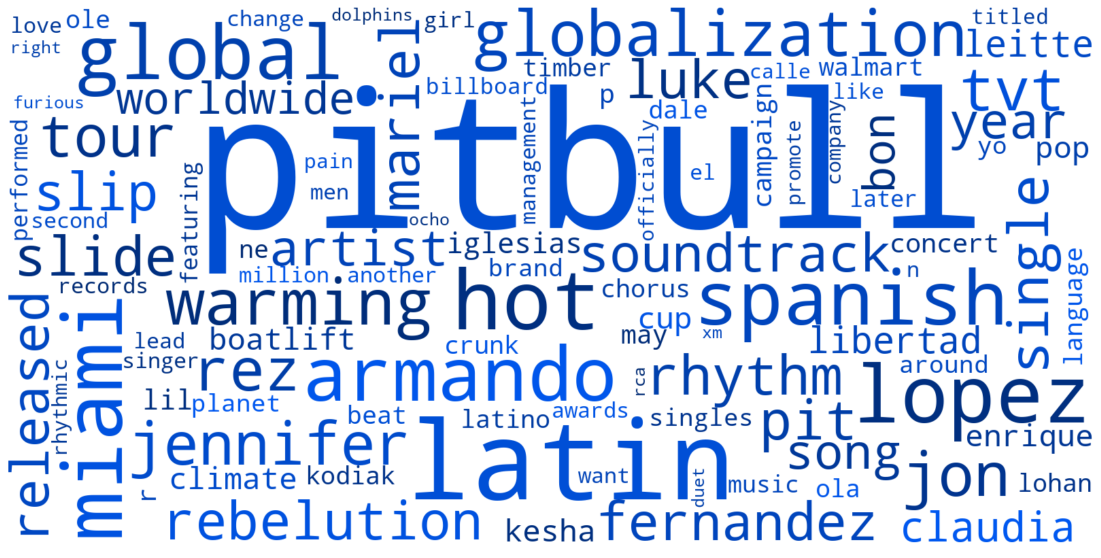

In [32]:
#Plotting a wordcloud on Wikipedia for Pitbull.
pitbull_wiki_wordcloud = WordCloud(background_color="white", 
                                max_words = 100, 
                                contour_color = 'firebrick',
                                color_func = color_wiki,
                                height = 800, 
                                width = 1600)

pitbull_wiki_wordcloud.generate_from_frequencies(pitbull_wiki_tfidf)

plt.figure( figsize=(20,10))
plt.imshow(pitbull_wiki_wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('pitbull_wordcloud_wiki.png')
plt.show()

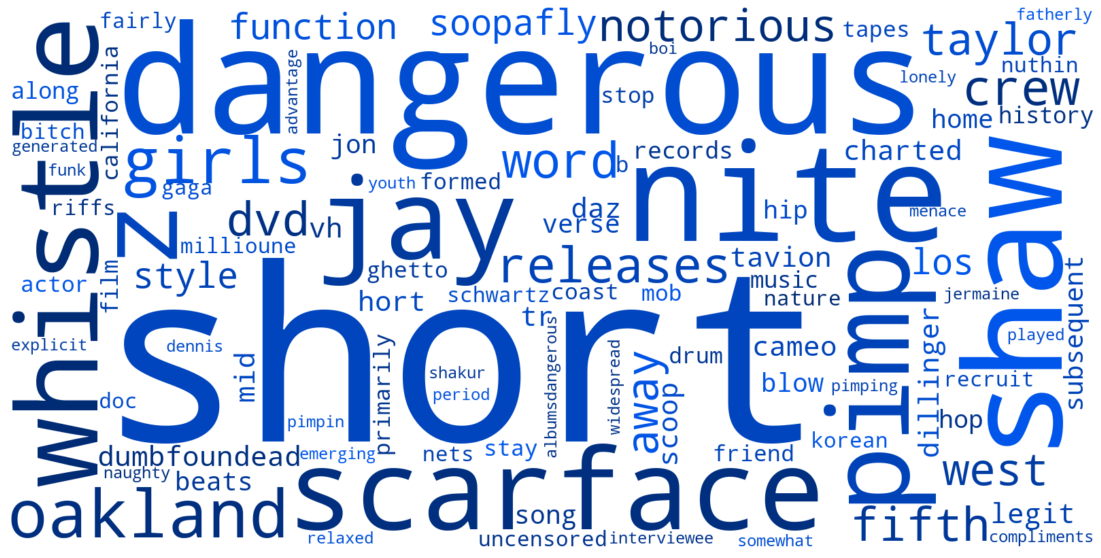

In [33]:
#Plotting a wordcloud on Wikipedia for Too $hort.
tooshort_wiki_wordcloud = WordCloud(background_color="white", 
                                max_words = 100, 
                                contour_color = 'firebrick',
                                color_func = color_wiki,
                                height = 800, 
                                width = 1600)

tooshort_wiki_wordcloud.generate_from_frequencies(tooshort_wiki_tfidf)

plt.figure( figsize=(20,10))
plt.imshow(tooshort_wiki_wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('tooshort_wordcloud_wiki.png')
plt.show()

Next is a representation of top ten most used words from each artist based on the choosen 5 songs. This has both been made on the lyrics and then the data from Wikipedia to see if there are a correlation between those two sources.

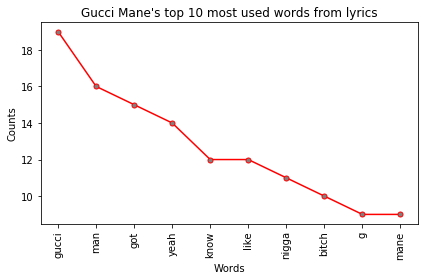

In [34]:
#Creating new dictionary, sorted based on value. Done both for lyrics and wiki.
sorted_guccimane_wordDict = sorted(guccimane_wordDict.items(), 
                                   key=lambda kv: kv[1], 
                                   reverse=True)

sorted_guccimane_wiki_wordDict = sorted(guccimane_wiki_wordDict.items(), 
                                   key=lambda kv: kv[1], 
                                   reverse=True)

#Zipped to create to list, which is being used to plot.
x, y = zip(*sorted_guccimane_wordDict)
x_wiki, y_wiki = zip(*sorted_guccimane_wiki_wordDict)

#Only the first 10 entries are used (highest values from sort)
x = x[:10]
y = y[:10]

x_wiki = x_wiki[:10]
y_wiki = y_wiki[:10]

#The words and their respective counts are plottet and then saved as png format.
plt.plot(x,y, color='red', marker='o',
     markerfacecolor='grey', markersize=5)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title("Gucci Mane's top 10 most used words from lyrics")
plt.xticks(x, rotation='vertical')
plt.tight_layout()
#plt.savefig('guccimane_top10_lyrics.png')
plt.show()

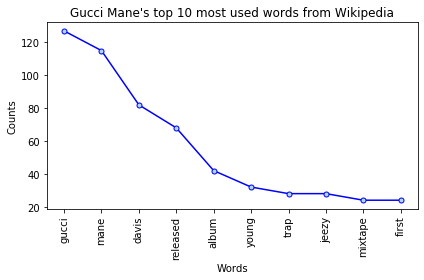

In [35]:
plt.plot(x_wiki,y_wiki, color='blue', marker='o',
     markerfacecolor='lightblue', markersize=5)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title("Gucci Mane's top 10 most used words from Wikipedia")
plt.xticks(x_wiki, rotation='vertical')
plt.tight_layout()
#plt.savefig('guccimane_top10_wiki.png')
plt.show()

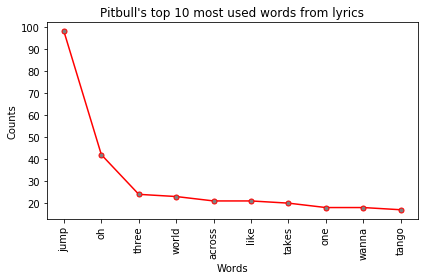

In [36]:
sorted_pitbull_wordDict = sorted(pitbull_wordDict.items(), 
                                   key=lambda kv: kv[1], 
                                   reverse=True)

sorted_pitbull_wiki_wordDict = sorted(pitbull_wiki_wordDict.items(), 
                                   key=lambda kv: kv[1], 
                                   reverse=True)

x, y = zip(*sorted_pitbull_wordDict)
x_wiki, y_wiki = zip(*sorted_pitbull_wiki_wordDict)

x = x[:10]
y = y[:10]

x_wiki = x_wiki[:10]
y_wiki = y_wiki[:10]

plt.plot(x,y, color='red', marker='o',
     markerfacecolor='grey', markersize=5)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title("Pitbull's top 10 most used words from lyrics")
plt.xticks(x, rotation='vertical')
plt.tight_layout()
#plt.savefig('pitbull_top10_lyrics.png')
plt.show()

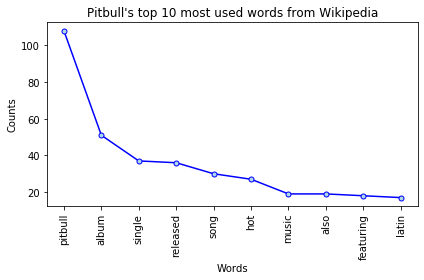

In [37]:
plt.plot(x_wiki,y_wiki, color='blue', marker='o',
     markerfacecolor='lightblue', markersize=5)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title("Pitbull's top 10 most used words from Wikipedia")
plt.xticks(x_wiki, rotation='vertical')
plt.tight_layout()
#plt.savefig('pitbull_top10_wiki.png')
plt.show()

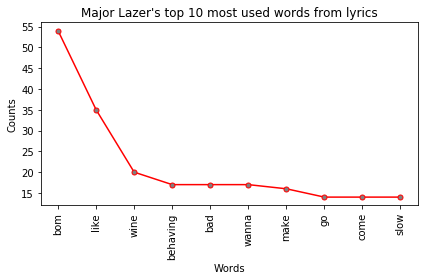

In [38]:
sorted_majorlazer_wordDict = sorted(majorlazer_wordDict.items(), 
                                   key=lambda kv: kv[1], 
                                   reverse=True)

sorted_majorlazer_wiki_wordDict = sorted(majorlazer_wiki_wordDict.items(), 
                                   key=lambda kv: kv[1], 
                                   reverse=True)

x, y = zip(*sorted_majorlazer_wordDict)
x_wiki, y_wiki = zip(*sorted_majorlazer_wiki_wordDict)

x = x[:10]
y = y[:10]

x_wiki = x_wiki[:10]
y_wiki = y_wiki[:10]

plt.plot(x,y, color='red', marker='o',
     markerfacecolor='grey', markersize=5)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title("Major Lazer's top 10 most used words from lyrics")
plt.xticks(x, rotation='vertical')
plt.tight_layout()
#plt.savefig('majorlazer_top10_lyrics.png')
plt.show()

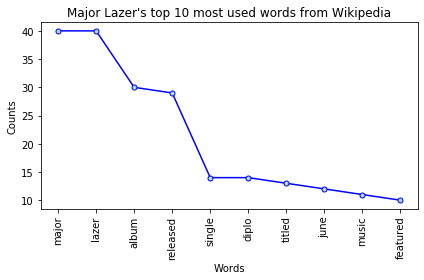

In [39]:
plt.plot(x_wiki,y_wiki, color='blue', marker='o',
     markerfacecolor='lightblue', markersize=5)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title("Major Lazer's top 10 most used words from Wikipedia")
plt.xticks(x_wiki, rotation='vertical')
plt.tight_layout()
#plt.savefig('majorlazer_top10_wiki.png')
plt.show()

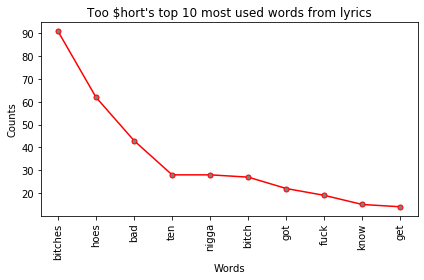

In [40]:
sorted_tooshort_wordDict = sorted(tooshort_wordDict.items(), 
                                   key=lambda kv: kv[1], 
                                   reverse=True)

sorted_tooshort_wiki_wordDict = sorted(tooshort_wiki_wordDict.items(), 
                                   key=lambda kv: kv[1], 
                                   reverse=True)

x, y = zip(*sorted_tooshort_wordDict)
x_wiki, y_wiki = zip(*sorted_tooshort_wiki_wordDict)

x = x[:10]
y = y[:10]

x_wiki = x_wiki[:10]
y_wiki = y_wiki[:10]

plt.plot(x,y, color='red', marker='o',
     markerfacecolor='grey', markersize=5)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title("Too $hort's top 10 most used words from lyrics")
plt.xticks(x, rotation='vertical')
plt.tight_layout()
#plt.savefig('tooshort_top10_lyrics.png')
plt.show()

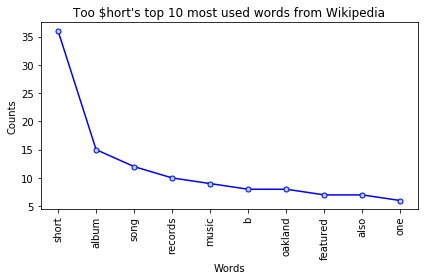

In [41]:
plt.plot(x_wiki,y_wiki, color='blue', marker='o',
     markerfacecolor='lightblue', markersize=5)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title("Too $hort's top 10 most used words from Wikipedia")
plt.xticks(x_wiki, rotation='vertical')
plt.tight_layout()
#plt.savefig('tooshort_top10_wiki.png')
plt.show()

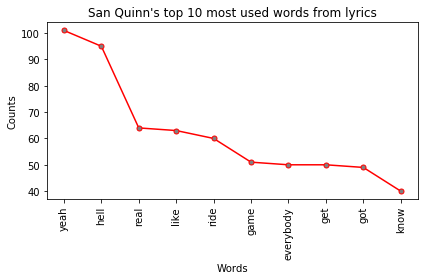

In [42]:
sorted_sanquinn_wordDict = sorted(sanquinn_wordDict.items(), 
                                   key=lambda kv: kv[1], 
                                   reverse=True)

sorted_sanquinn_wiki_wordDict = sorted(sanquinn_wiki_wordDict.items(), 
                                   key=lambda kv: kv[1], 
                                   reverse=True)

x, y = zip(*sorted_sanquinn_wordDict)
x_wiki, y_wiki = zip(*sorted_sanquinn_wiki_wordDict)

x = x[:10]
y = y[:10]

x_wiki = x_wiki[:10]
y_wiki = y_wiki[:10]

plt.plot(x,y, color='red', marker='o',
     markerfacecolor='grey', markersize=5)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title("San Quinn's top 10 most used words from lyrics")
plt.xticks(x, rotation='vertical')
plt.tight_layout()
#plt.savefig('sanquinn_top10_lyrics.png')
plt.show()

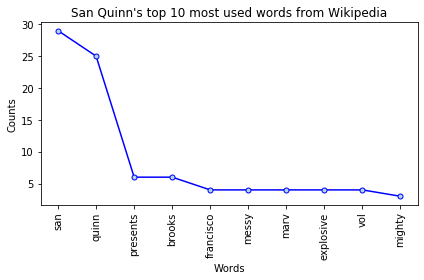

In [43]:
plt.plot(x_wiki,y_wiki, color='blue', marker='o',
     markerfacecolor='lightblue', markersize=5)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title("San Quinn's top 10 most used words from Wikipedia")
plt.xticks(x_wiki, rotation='vertical')
plt.tight_layout()
#plt.savefig('sanquinn_top10_wiki.png')
plt.show()

This analysis made is clear on which words are more likely to be used by a given artist. Here it is seen that Too $hort are more likely to say explicit words in his songs and compared to his Wikipedia wordcloud. This might also has to do with that the lyrics are written by himself, which is subjective and the Wikipedia page are more likely to be Objective due to that everybody have access to edit and add information.

The two most used words by Too $hort is two swearwords and the two most used word on his Wikipedia page is just words which describe the artist.

From the wordclouds it can give an image on which types of words distinguish the artist from the other four and from there give an impression on what the meaning of the choosen five songs from each artist is about. 

# Sentiment analysis

In [52]:
import csv
sentiment = requests.get('https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001').text
reader = csv.reader(io.StringIO(sentiment), delimiter='\t')
lines = [l for l in reader]
header = lines[3]
data = lines[4:]
sentiment_dict = {}
for line in data:
    sentiment_dict[line[0]] = float(line[2])

In [156]:
def calculate_sentiment(tokens, labMT):
    return np.sum([labMT[t] for t in tokens if t in labMT.keys()])

def calculate_sentiment_norm(tokens, labMT):
    sentiments = [labMT[t] for t in tokens if t in labMT.keys()]
    return np.mean(sentiments)

def calculate_sentiment_median(tokens, labMT):
    sentiments = [labMT[t] for t in tokens if t in labMT.keys()]
    return np.median(sentiments)




Calculating the sentiemnts according to the labMT analysis we get a good grasp whether the lyrics and wikipages are positive or negative.
Below we calculate both the mean, the median as well as the sum for the sentiment score. We have plotted different versions in order to show the easiest readable result. 

In [208]:
pitbull = open('lyric/pitbull.txt', "r")
pitbull_text = pitbull.read()
pitbull.close()

In [211]:
featuringArtist = ["pitbull", "guccimane", "majorlazer", "tooshort", "sanquinn"]

#Calculate the sentiment score of pitbull store in list
sentiment_pitbull = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in pitbull_text
]


sentiment_pitbull_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in pitbull_text
]

sentiment_pitbull_median = [
    calculate_sentiment_median(ts, sentiment_dict) 
    for ts in pitbull_text
]

sentiment_Gucci = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in guccimane_text
]

sentiment_gucci_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in guccimane_text
]

sentiment_gucci_median = [
    calculate_sentiment_median(ts, sentiment_dict) 
    for ts in guccimane_text
]

sentiment_Major = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in majorlazer_text
]

sentiment_major_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in majorlazer_text
]

sentiment_major_median = [
    calculate_sentiment_median(ts, sentiment_dict) 
    for ts in majorlazer_text
]

sentiment_tooshort = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in tooshort_text
]

sentiment_tooshort_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in tooshort_text
]

sentiment_tooshort_median = [
    calculate_sentiment_median(ts, sentiment_dict) 
    for ts in tooshort_text
]


sentiment_Sanquinn = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in sanquinn_text
]

sentiment_sanquinn_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in sanquinn_text
]

sentiment_sanquinn_median = [
    calculate_sentiment_median(ts, sentiment_dict) 
    for ts in sanquinn_text
]




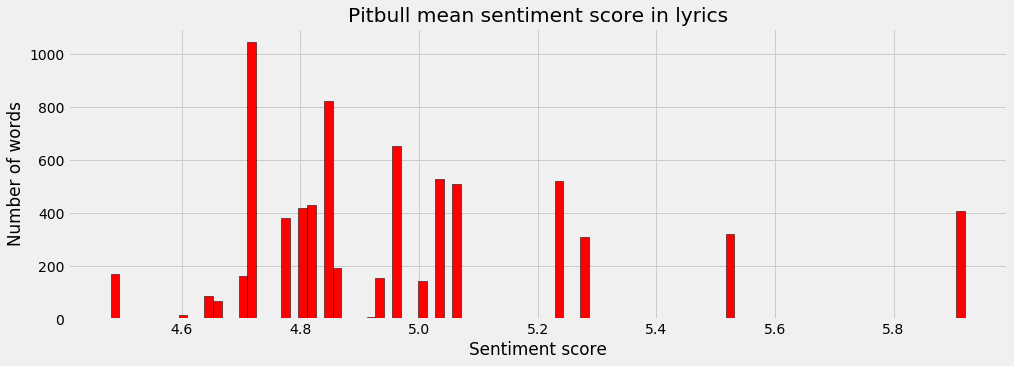

In [212]:
plt.figure(figsize=[15,5])

plt.hist(sentiment_pitbull_normalized, color="red", bins=100, edgecolor="black")
plt.title("Pitbull mean sentiment score in lyrics")
plt.xlabel("Sentiment score")
plt.ylabel("Number of words")
plt.savefig('Pitbull_sentiment.png')
plt.show()



Pitbull seems to be one of the nicer ones considering the histogram just above. Since the words are more towards the middle (5)

If one ccheck out the analysis of $Too Short it is a bit of a different picture.

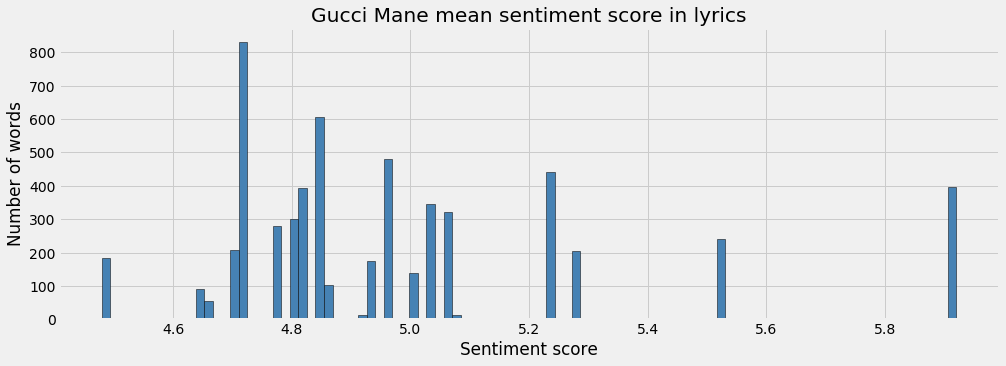

In [213]:
plt.figure(figsize=[15,5])
plt.hist(sentiment_gucci_normalized, color="steelblue", bins=100, edgecolor="black")
plt.title("Gucci Mane mean sentiment score in lyrics")
plt.xlabel("Sentiment score")
plt.ylabel("Number of words")
plt.savefig('Guccimane_sentiment.png')
plt.show()

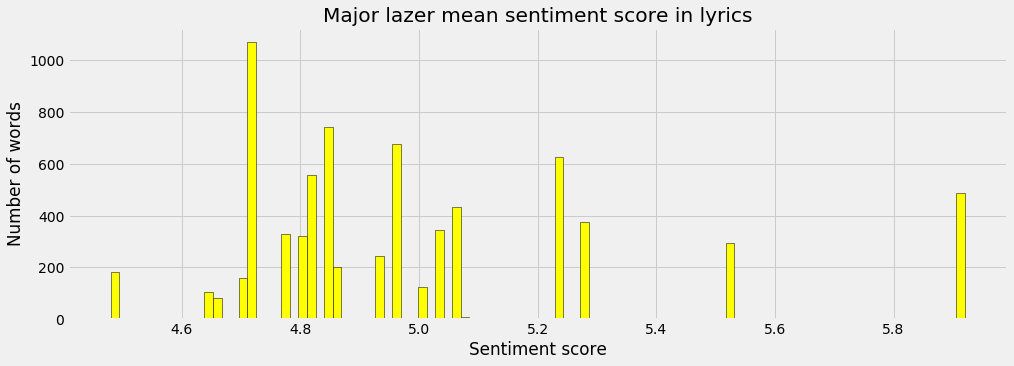

In [214]:
plt.figure(figsize=[15,5])
plt.hist(sentiment_major_normalized, color="yellow", bins=100, edgecolor="black")
plt.title("Major lazer mean sentiment score in lyrics")
plt.xlabel("Sentiment score")
plt.ylabel("Number of words")
plt.savefig('MajorLazer_sentiment.png')
plt.show()

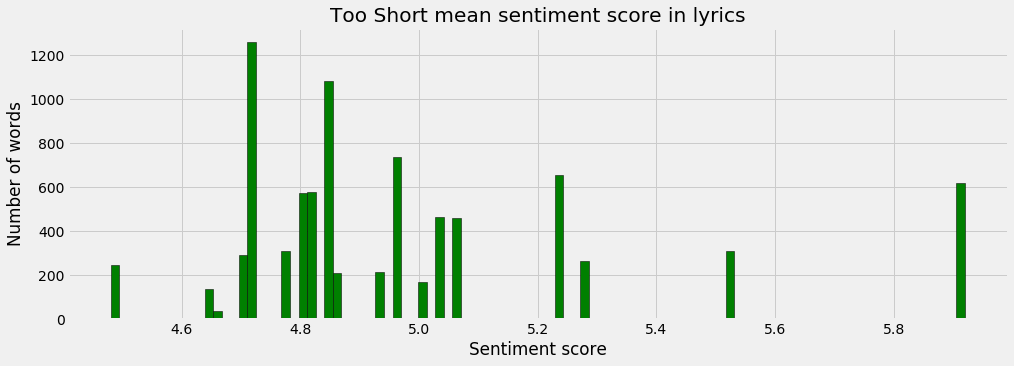

In [215]:
plt.figure(figsize=[15,5])
plt.hist(sentiment_tooshort_normalized, color="green", bins=100, edgecolor="black")
plt.title("Too Short mean sentiment score in lyrics")
plt.xlabel("Sentiment score")
plt.ylabel("Number of words")
plt.savefig('TooShort_sentiment.png')
plt.show()

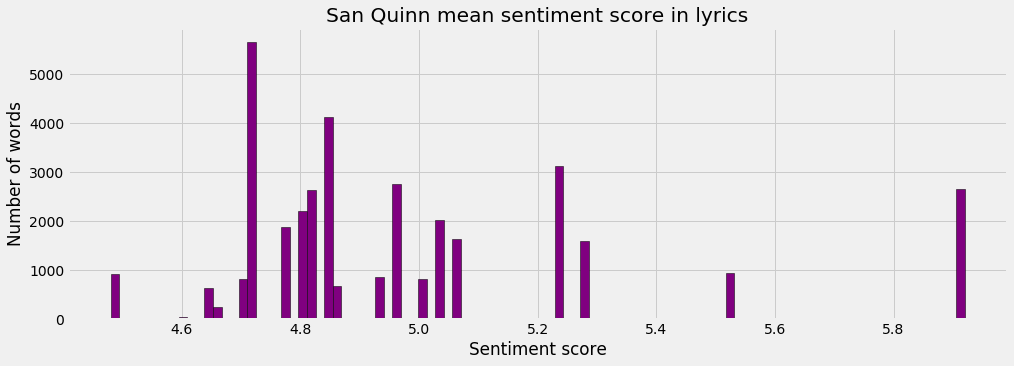

In [216]:
plt.figure(figsize=[15,5])

plt.hist(sentiment_sanquinn_normalized, color="purple", bins=100, edgecolor="black")
plt.title("San Quinn mean sentiment score in lyrics")
plt.xlabel("Sentiment score")
plt.ylabel("Number of words")
plt.savefig('SanQuinn1_sentiment.png')
plt.show()

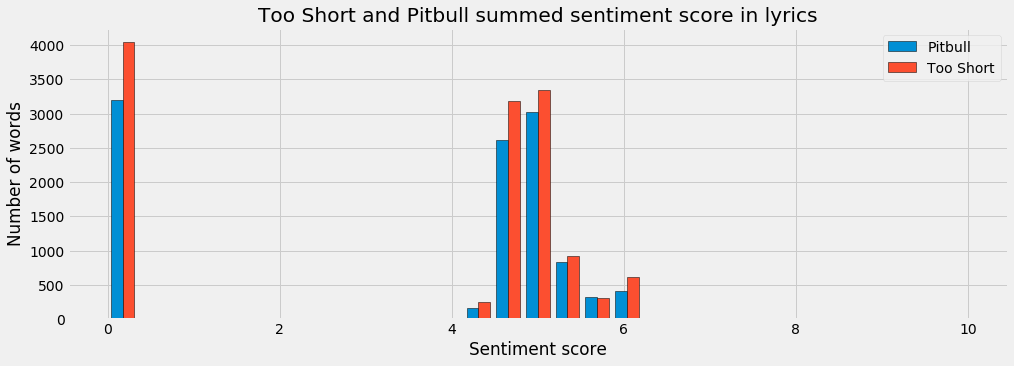

In [217]:
bins = np.linspace(0, 10, 30)
plt.style.use('fivethirtyeight')

plt.figure(figsize=[15,5])

y = (sentiment_tooshort)
x = (sentiment_pitbull)

plt.hist([x, y], bins, label=['Pitbull', 'Too Short'], edgecolor="black")
plt.legend(loc='upper right')

plt.title("Too Short and Pitbull summed sentiment score in lyrics")
plt.xlabel("Sentiment score")
plt.ylabel("Number of words")

plt.savefig('PitbullTooShortsentiment.png')
plt.show()

Comparing to artist like Pitbull and Too Short gives an idea that the sentiments are not that different. They are around the same area though Too Short seems to have a bit more in the low area indicating a more negative language than Pitbull.
Too Short was rather aggressive found in the wordcloud before. While Pitbull was less aggressive. Plotting the two graphs next to each other gives a view of that difference. The higher a score the less agressive the word use. 

The very high bar at the low sentiment score indicates that the language is negative. However it is clear to see that the green bar is higher. The green bar is Too Short's bar.

In [218]:
tokenizePitbullLyrics = []
tokenizeSanQuinnLyrics = []
tokenizeTooshortLyrics = []
tokenizeMajorlazerLyrics = []
tokenizeGuccimaneLyrics = []

pitbulltokens = word_tokenize(pitbull_text)

tokenizePitbullLyrics.append(pitbull_split)

majorlazertokens = word_tokenize(majorlazer_text)
tooshorttokens = word_tokenize(tooshort_text)
guccimanetokens = word_tokenize(guccimane_text)
sanquinntokens = word_tokenize(sanquinn_text)

In [4]:

avg = np.mean(sentiment_Major + sentiment_tooshort + sentiment_pitbull + sentiment_Gucci + sentiment_Sanquinn)
std = np.std(sentiment_Major + sentiment_tooshort + sentiment_pitbull + sentiment_Gucci + sentiment_Sanquinn)



NameError: name 'sentiment_Major' is not defined

### Wiki Sentiment analysis

In [220]:
pitbullwiki = open('wiki/pitbull.txt', "r")
pitbull_wikitext = pitbullwiki.read()
pitbullwiki.close()

sanquinnwiki = open('wiki/sanquinn.txt', "r")
sanquinn_wikitext = sanquinnwiki.read()
sanquinnwiki.close()

tooshortwiki = open('wiki/tooshort.txt', "r")
tooshort_wikitext = tooshortwiki.read()
tooshortwiki.close()

majortlazerwiki = open('wiki/majorlazer.txt', "r")
majorlazer_wikitext = majortlazerwiki.read()
majortlazerwiki.close()


guccimanewiki = open('wiki/guccimane.txt', "r")
guccimane_wikitext = guccimanewiki.read()
guccimanewiki.close()



In [221]:
#Calculate the sentiment score of pitbull store in list
sentiment_pitbull_wiki = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in pitbull_wikitext
]


sentiment_pitbull_wiki_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in pitbull_wikitext
]

sentiment_pitbull_wiki_median = [
    calculate_sentiment_median(ts, sentiment_dict) 
    for ts in pitbull_wikitext
]

sentiment_Gucci_wiki = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in guccimane_wikitext
]

sentiment_gucci_wiki_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in guccimane_wikitext
]

sentiment_gucci_wiki_median = [
    calculate_sentiment_median(ts, sentiment_dict) 
    for ts in guccimane_wikitext
]

sentiment_Major_wiki = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in majorlazer_wikitext
]

sentiment_major_wiki_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in majorlazer_wikitext
]

sentiment_major_wiki_median = [
    calculate_sentiment_median(ts, sentiment_dict) 
    for ts in majorlazer_wikitext
]

sentiment_tooshort_wiki = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in tooshort_wikitext
]

sentiment_tooshort_wiki_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in tooshort_wikitext
]

sentiment_tooshort_wiki_median = [
    calculate_sentiment_median(ts, sentiment_dict) 
    for ts in tooshort_wikitext
]


sentiment_Sanquinn_wiki = [
    calculate_sentiment(ts, sentiment_dict) 
    for ts in sanquinn_wikitext
]

sentiment_sanquinn_wiki_normalized = [
    calculate_sentiment_norm(ts, sentiment_dict) 
    for ts in sanquinn_wikitext
]

sentiment_sanquinn_wiki_median = [
    calculate_sentiment_median(ts, sentiment_dict) 
    for ts in sanquinn_wikitext
]





/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


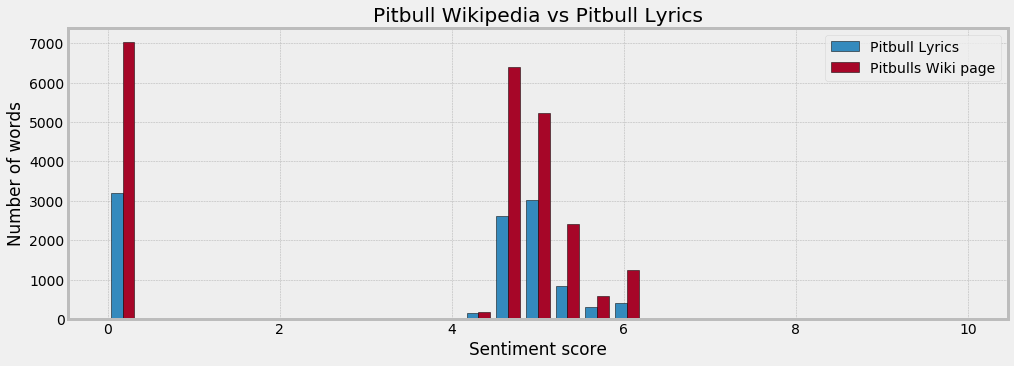

In [235]:
bins = np.linspace(0, 10, 30)
plt.style.use('bmh')

plt.figure(figsize=[15,5])

y = (sentiment_pitbull_wiki)
x = (sentiment_pitbull)

plt.hist([x, y], bins, label=['Pitbull Lyrics', 'Pitbulls Wiki page'], edgecolor="black")
plt.legend(loc='upper right')

plt.title("Pitbull Wikipedia vs Pitbull Lyrics")
plt.xlabel("Sentiment score")
plt.ylabel("Number of words")

plt.savefig('pitbull_wiki_lyric.png')
plt.show()


So here we are comparing the Sentiment score on the lyrics site to the wikipage. What seems to be the pattern in all cases is that what the artist sing about and the weight of the words in the lyrics are similar to the weight of the words in the wiki site

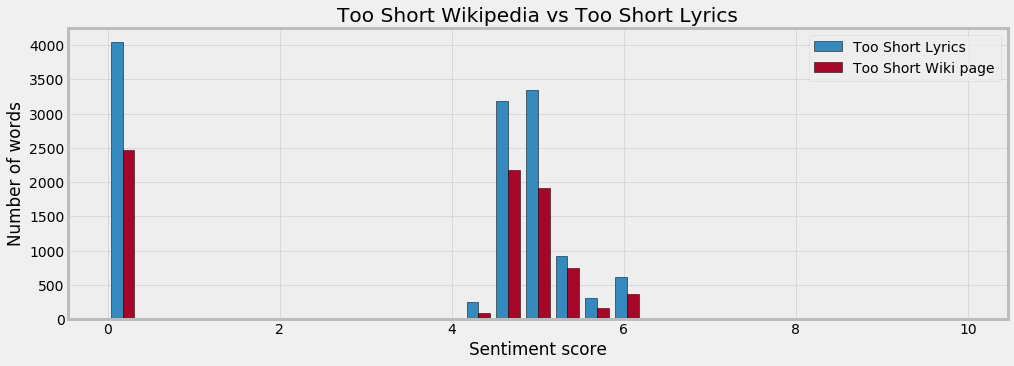

In [230]:
bins = np.linspace(0, 10, 30)
plt.style.use('bmh')

plt.figure(figsize=[15,5])

y = (sentiment_tooshort_wiki)
x = (sentiment_tooshort)

plt.hist([x, y], bins, label=['Too Short Lyrics', 'Too Short Wiki page'], edgecolor="black")
plt.legend(loc='upper right')

plt.title("Too Short Wikipedia vs Too Short Lyrics")
plt.xlabel("Sentiment score")
plt.ylabel("Number of words")

plt.savefig('tooshort_wiki_lyric.png')
plt.show()

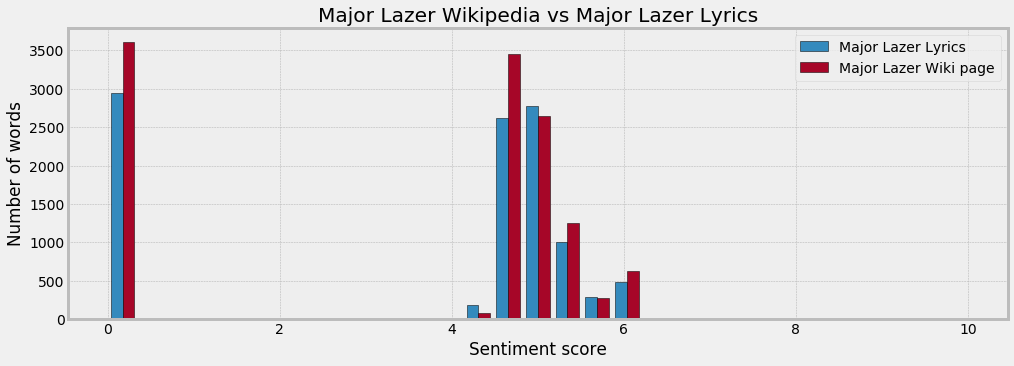

In [231]:
bins = np.linspace(0, 10, 30)
plt.style.use('bmh')

plt.figure(figsize=[15,5])

y = (sentiment_Major_wiki)
x = (sentiment_Major)

plt.hist([x, y], bins, label=['Major Lazer Lyrics', 'Major Lazer Wiki page'], edgecolor="black")
plt.legend(loc='upper right')

plt.title("Major Lazer Wikipedia vs Major Lazer Lyrics")
plt.xlabel("Sentiment score")
plt.ylabel("Number of words")

plt.savefig('majorlazer_wiki_lyric.png')
plt.show()

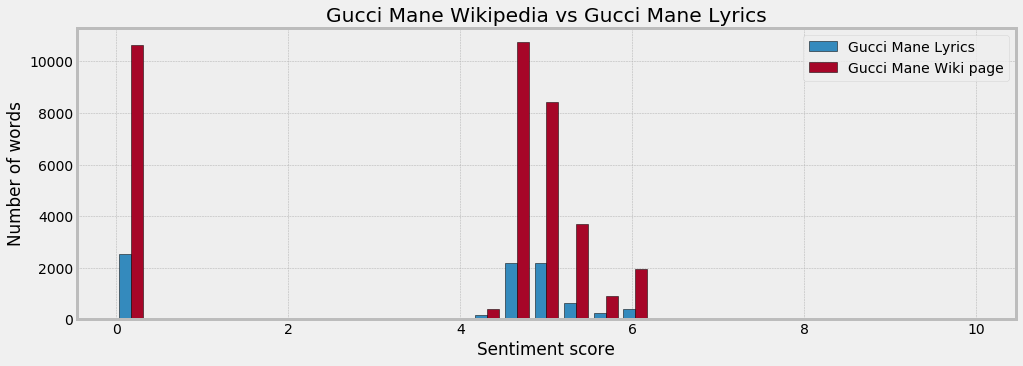

In [232]:
bins = np.linspace(0, 10, 30)
plt.style.use('bmh')

plt.figure(figsize=[15,5])

y = (sentiment_Gucci_wiki)
x = (sentiment_Gucci)

plt.hist([x, y], bins, label=['Gucci Mane Lyrics', 'Gucci Mane Wiki page'], edgecolor="black")
plt.legend(loc='upper right')

plt.title("Gucci Mane Wikipedia vs Gucci Mane Lyrics")
plt.xlabel("Sentiment score")
plt.ylabel("Number of words")

plt.savefig('guccimane_wiki_lyric.png')
plt.show()

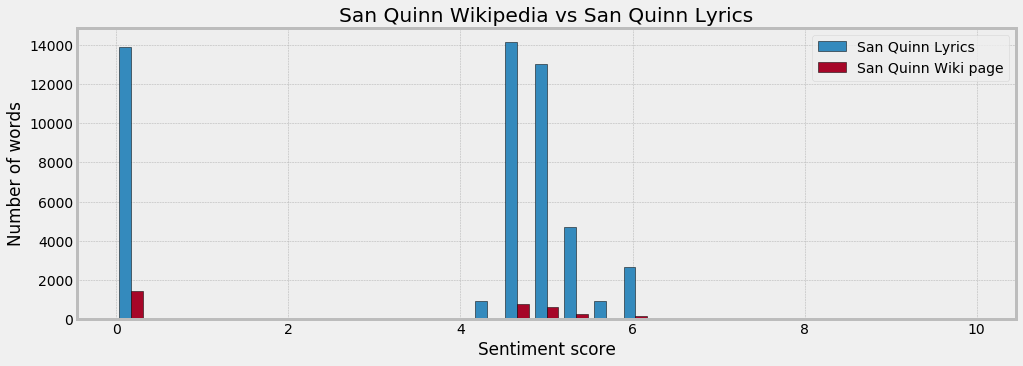

In [233]:
bins = np.linspace(0, 10, 30)
plt.style.use('bmh')

plt.figure(figsize=[15,5])

y = (sentiment_Sanquinn_wiki)
x = (sentiment_Sanquinn)

plt.hist([x, y], bins, label=['San Quinn Lyrics', 'San Quinn Wiki page'], edgecolor="black")
plt.legend(loc='upper right')

plt.title("San Quinn Wikipedia vs San Quinn Lyrics")
plt.xlabel("Sentiment score")
plt.ylabel("Number of words")

plt.savefig('sanquinn_wiki_lyric.png')
plt.show()

### Contribution to the project:

Hjalte: Network generation (Spotify API), Network analysis, Audio analysis, motivation and discussion.

Phillip: Wikipedia API, Interactive network, Lyrics Analysis (TF-IDF)+Wiki Analysis (TF-IDF), Data preparation and tools section. 10% Github homepage 

Maria: Sentiment analysis, 90 % Github homepage, Lyrics Genious